In [ ]:
"""
Цель:

Сегментировать клиентов на группы с похожими финансовыми поведенческими паттернами, чтобы банк мог:

Персонализировать маркетинговые кампании (например, предлагать кредиты или премиальные карты).

Выявлять риски (клиенты с низкой платежеспособностью).

Оптимизировать кредитные лимиты и условия обслуживания.


BALANCE :: Сумма на счету
BALANCE_FREQUENCY : Частота обновления баланса, оценка от 0 до 1 (1 = часто обновляется, 0 = не часто обновляется)
PURCHASES : Количество покупок со счета
ONEOFF_PURCHASES : Максимальная сумма покупок, совершенных за один раз
INSTALLMENTS_PURCHASES : Сумма покупки в рассрочку
CASH_ADVANCE : Аванс наличными, выданный пользователем
PURCHASES_FREQUENCY : Частота совершения покупок, оценка от 0 до 1 (1 = часто покупают, 0 = не часто покупают)
ONEOFFPURCHASESFREQUENCY : Как часто покупки совершаются за один раз (1 = часто покупают, 0 = не часто покупают)
PURCHASESINSTALLMENTSFREQUENCY : Насколько часто совершаются покупки в рассрочку (1 = часто, 0 = не часто)
CASHADVANCEFREQUENCY : Как часто выплачиваются авансовые платежи наличными.
CASHADVANCETRX : Количество транзакций, совершенных с использованием «наличных в рассрочку»
PURCHASES_TRX : Количество совершенных операций с покупками
CREDIT_LIMIT : Лимит кредитной карты
PAYMENTS  : Сумма платежей пользователя
MINIMUM_PAYMENTS : Минимальная сумма платежей пользователя
PRCFULLPAYMENT : Процент от полного платежа, уплаченного пользователем
TENURE : Срок обслуживания кредитной карты

"""

In [102]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import hw_utils_package as hw
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_linnerud
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [103]:
# Загрузка данных
try:
    df = hw.fromKaggelhubCSV("arjunbhasin2013/ccdata", "CC GENERAL.csv")
    print("Данные успешно загружены.")
except FileNotFoundError:
    print("Ошибка: Файл 'CC GENERAL.csv' не найден. Убедитесь, что файл находится в правильной директории.")
    df = None #  Если файл не найден, дальнейший код не будет работать
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")
    df = None #  Если произошла ошибка, дальнейший код не будет работать

INFO:hw_utils_package.fetchData:Fetching file by url on 2025-04-04 Time 02:25:06+00:00 UTC


Данные успешно загружены.


In [104]:
# Полезные функции
# Вывод разделителя на экран
def print_splitter():
    print("-" * 80)

# Выводит первые 5 строк в DataFrame.
def df_head_5(df):
    print("Первые 5 строк DataFrame:")
    print(df.head(5))  
    print_splitter()

# Выводит описание статистик DataFrame
def df_describe(df):
    print("Описание статистик DataFrame:")
    print(df.describe()) 
    print_splitter()

# Выводит информацию о типах данных, количестве не-NaN значений в DataFrame.
def df_info(df):
    print("Информация о DataFrame:")
    print(df.describe())
    print_splitter()

# Выводит информацию о типах данных, количестве не-NaN значений в DataFrame.
def df_shape(df):
    print("Форма DataFrame:")
    print(df.shape)
    print_splitter()

# Проверка на пропущенные значения (NaN/Null)
# Вычисляет и выводит количество пропущенных значений (NaN/Null) в DataFrame.
def check_missing_values(df):
    total_missing = df.isnull().values.sum()  # Суммируем все пропущенные значения
    print(f"В DataFrame содержится {total_missing} пропущенных значений (NaN/Null).")
    # Проверка доли пропусков в каждом столбце
    missing_percent = df.isnull().mean() * 100
    print(missing_percent.sort_values(ascending=False))
    print_splitter()
    
# Проверка на дубликаты
# Вычисляет и выводит количество дубликатов строк в DataFrame.
def check_duplicates(df):
    num_duplicates = df.duplicated().sum()  # Считаем количество дубликатов
    print(f"В DataFrame обнаружено {num_duplicates} дубликатов строк.")
    print_splitter()
# Описывает типы данных и значения колонок DataFrame.
def describe_dataframe_columns(df):
    print("Типы данных колонок:")
    print(df.dtypes)
    print("-" * 30)  # Разделитель
    print("Описание значений колонок:")
    for column in df.columns:
        print(f"Колонка: {column}")
        try:
            # Попытка описать числовые колонки
            print(df[column].describe())
        except:
            # Если не числовая, описываем как строку (или другой тип)
            print(f"Тип: {df[column].dtype}")
            print(f"Количество уникальных значений: {df[column].nunique()}")
            print(f"Примеры уникальных значений: {df[column].unique()[:5]}...")  # Показываем первые 5 уникальных

        print("-" * 15)  # Разделитель для каждой колонки
def print_dictionary(label, data):
    """
    Выводит содержимое словаря в формате "ключ: значение".

    Args:
        data (dict): Словарь для вывода.
    """
    print(label)
    for key, value in data.items(): # Используем .items() для итерации по ключам и значениям
        print(f"{key}: {value}")
    print_splitter()
    
#Визуализирует пропущенные значения в DataFrame с помощью тепловой карты.
def visualize_missing_values(df: pd.DataFrame, title: str = 'Heatmap пропущенных значений'):
   
    plt.figure(figsize=(10, 6))  # Увеличиваем размер графика для лучшей читаемости (опционально)
    plt.xticks(rotation=135, ha='right')
    plt.tight_layout()
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

    # Устанавливаем заголовок графика.
    plt.title(title)

    # Отображаем график.
    plt.show()
    
#Заполняем пропущенные значения: числовые столбцы - медианным значением
def fill_gap(df: pd.DataFrame):
    """
    Заполняет пропущенные значения в числовых столбцах медианой.
    Выводит информацию о количестве пропусков до и после заполнения.
    """
    if df is None:
        print("DataFrame равен None. Пропуск анализа.")
        return

    print("Заполнение пропущенных значений...")
    print_splitter()

    # 1. Анализ пропусков до заполнения
    print("Анализ пропусков перед заполнением:")
    for col in df.select_dtypes(include=['number']).columns:
        analyze_column_missing_values(df, col)  # Используем вспомогательную функцию

    # 2. Заполнение пропусков
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median(numeric_only=True))

    # 3. Анализ пропусков после заполнения
    print("Анализ пропусков после заполнения:")
    for col in df.select_dtypes(include=['number']).columns:
        analyze_column_missing_values(df, col)  # Используем вспомогательную функцию

    print_splitter()
    print("Заполнение пропусков завершено.")

def analyze_column_missing_values(df: pd.DataFrame, column_name: str):
    """
    Анализирует количество и процент пропущенных значений в указанном столбце.
    """
    if df is None:
        print("DataFrame равен None. Пропуск анализа.")
        return
        
    null_count = df[column_name].isnull().sum()
    if null_count > 0:
        print(f"В столбце '{column_name}' содержится {null_count} пропущенных значений (NaN/Null).")
        null_percentage = (null_count / len(df) * 100)
        print(f"Процент пропущенных значений: {null_percentage:.2f}%")
    else:
        print(f"В столбце '{column_name}' нет пропущенных значений.")

#Заполняем пропущенные значения - медианным значением
def fill_gap_column(df: pd.DataFrame, column_name: str):
    if df is None:
        print("DataFrame равен None. Пропуск анализа.")
        return

    print("Заполнение пропущенных значений...")
    print_splitter()

    # 1. Анализ пропусков до заполнения
    print(f"Анализ пропусков перед заполнением: {column_name}")
    analyze_column_missing_values(df, column_name)

    # 2. Заполнение пропусков
    df[column_name] = df[column_name].fillna(df[column_name].median(numeric_only=True))

    # 3. Анализ пропусков после заполнения
    print(f"Анализ пропусков после заполнения: {column_name}")
    analyze_column_missing_values(df, column_name)

    print_splitter()
    print("Заполнение пропусков завершено.")

def analyze_column(df: pd.DataFrame, column_name: str):
    if df is None:
        print("DataFrame равен None. Пропуск анализа.")
        return
    
    print(f"Анализ переменной {column_name}:")
    print(df[column_name].describe())
    
    null_count = df[column_name].isnull().sum().sum()
    print(f"В {column_name} содержится {null_count} пропущенных значений (NaN/Null).")

    analyze_column_missing_values(df, column_name)

    # Создаем фигуру и оси для двух графиков
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 строка, 2 столбца

    # Гистограмма
    sns.histplot(df[column_name], kde=True, ax=axes[0])  # kde добавляет кривую плотности
    axes[0].set_title(f'Распределение {column_name}', fontsize=14)
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Частота')

    # Boxplot
    sns.boxplot(data=df[[column_name]], ax=axes[1])
    axes[1].set_title(f'Ящик с усами для выявления выбросов {column_name}', fontsize=16)

    plt.tight_layout()  # Для избежания наложения заголовков и меток
    plt.show()

def detect_outliers(df: pd.DataFrame, column: str, method='iqr', threshold=1.5, return_indices=False):
    """
    Обнаруживает выбросы в заданном столбце DataFrame.

    Args:
        df (pd.DataFrame): Входной DataFrame.
        column (str): Название столбца, в котором нужно искать выбросы.
        method (str, optional): Метод обнаружения выбросов. Доступны:
            - 'iqr': Межквартильный размах (IQR).
            - 'zscore': Z-оценка.
        threshold (float, optional): Пороговое значение для определения выбросов. 
                                      Для IQR: множитель IQR.
                                      Для Z-оценки: абсолютное значение Z-оценки.
                                      По умолчанию 1.5 (для IQR) и 3 (для Z-оценки).
        return_indices (bool, optional):  Если True, возвращает индексы строк с выбросами.
                                          По умолчанию False (возвращает DataFrame с выбросами).

    Returns:
        pd.DataFrame или np.array: DataFrame с выбросами или массив индексов выбросов.
                                   Возвращает None, если в столбце обнаружены только NaN значения.
    """

    if df[column].isnull().all():
        print(f"В столбце '{column}' содержатся только NaN значения. Выбросы не могут быть определены.")
        return None

    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        if return_indices:
            return outliers.index.to_numpy()
        else:
            return outliers

    elif method == 'zscore':
        z = np.abs((df[column] - df[column].mean()) / df[column].std())
        outliers = df[z > threshold]
        if return_indices:
            return outliers.index.to_numpy()
        else:
            return outliers
    else:
        raise ValueError("Неверный метод обнаружения выбросов. Доступные методы: 'iqr', 'zscore'.")

def detect_outliers_iqr(df: pd.DataFrame, column: str):
    outliers_iqr = detect_outliers(df, column, method='iqr')
    
    if outliers_iqr is not None:
        print(f"Выбросы в столбце '{column}' (IQR):")
        print(outliers_iqr)
        print(f"Количество выбросов (IQR): {len(outliers_iqr)}")
        # Анализ других столбцов для выбросов, найденных в column
        for col in df.columns:
            if col != column and pd.api.types.is_numeric_dtype(df[col]):
                outliers_indices = detect_outliers(df, column, method='iqr', return_indices=True)
                if outliers_indices is not None and len(outliers_indices)>0:
                    outliers_in_other_col = df.loc[outliers_indices, col]
                    if len(outliers_in_other_col) > 0:
                        print(f"Анализ столбца '{col}' для выбросов, связанных с выбросами в '{column}':")
                        print(outliers_in_other_col.describe())
    else:
        print(f"В столбце '{column}' не обнаружено выбросов (IQR).")


def detect_outliers_zscore(df: pd.DataFrame, column: str):
    outliers_zscore = detect_outliers(df, column, method='zscore', threshold=3)
    
    if outliers_zscore is not None:
        print(f"Выбросы в столбце '{column}' (Z-оценка):")
        print(outliers_zscore)
        print(f"Количество выбросов (Z-оценка): {len(outliers_zscore)}")
    else:
        print(f"В столбце '{column}' не обнаружено выбросов (Z-оценка).")

Первые 5 строк DataFrame:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1         

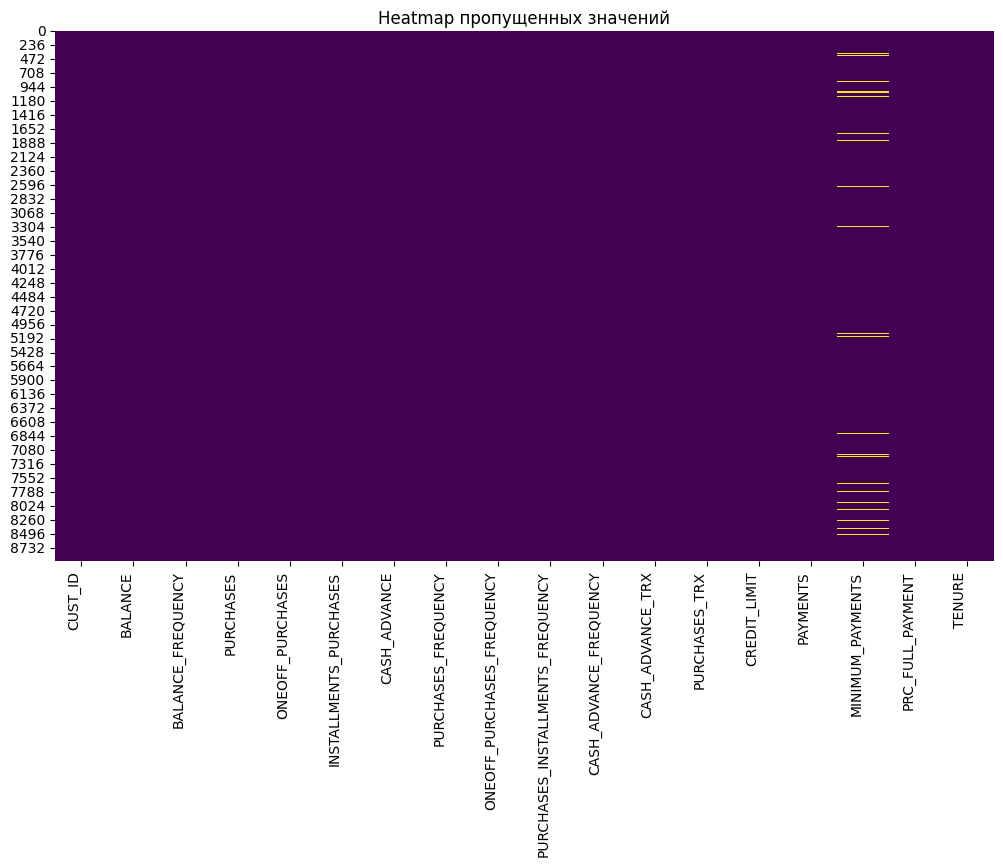

In [4]:
# Разведочный анализ данных EDA (Exploratory Data Analysis)
# Первичный анализ данных
if df is not None:
    # Первые 5 строк DataFrame:
    df_head_5(df)

    # Форма DataFrame:
    df_shape(df)
    
    # Описывает типы данных и значения колонок DataFrame.
    describe_dataframe_columns(df)    
    
    # Проверка на дубликаты:
    check_duplicates(df)
    
    # Проверка на пропущенные значения:
    check_missing_values(df)
    
    #Визуализирует пропущенные значения в DataFrame с помощью тепловой карты.
    visualize_missing_values(df)
else:
    print("DataFrame 'df' не определен. Пожалуйста, загрузите данные в DataFrame.")


In [ ]:
'''
Общая картина: У нас есть данные о почти 9000 клиентах и 18 характеристиках, описывающих их расходы и поведение с кредитными картами.

Основные характеристики:
BALANCE: Средний остаток на счете - около 1564. У некоторых клиентов очень большие остатки (до 19000).
BALANCE_FREQUENCY: Как часто обновляется баланс. В среднем, баланс обновляется часто (около 0.88).
PURCHASES: Общая сумма покупок. В среднем, клиенты тратят около 1003, но разброс очень большой (от 0 до 49000).
ONEOFF_PURCHASES: Покупки одним платежом. Среднее около 592, что показывает, что клиенты совершают как крупные, так и мелкие покупки.
INSTALLMENTS_PURCHASES: Покупки в рассрочку. В среднем, около 411.
CASH_ADVANCE: Снятие наличных. В среднем 978. Разброс большой, значит, кто-то часто снимает, а кто-то вообще не пользуется этой функцией.
PURCHASES_FREQUENCY: Как часто совершаются покупки. В среднем около 0.49. Это значит, что покупки совершаются не очень часто.
ONEOFF_PURCHASES_FREQUENCY: Как часто совершаются покупки одним платежом. В среднем около 0.20.
PURCHASES_INSTALLMENTS_FREQUENCY: Как часто совершаются покупки в рассрочку. В среднем около 0.36.
CASH_ADVANCE_FREQUENCY: Как часто снимают наличные. В среднем около 0.13.
CASH_ADVANCE_TRX: Количество операций по снятию наличных.
PURCHASES_TRX: Количество покупок. В среднем около 14.
CREDIT_LIMIT: Кредитный лимит. В среднем около 4494.
PAYMENTS: Сумма платежей. В среднем около 1733.
MINIMUM_PAYMENTS: Минимальный платеж. В среднем около 864. Есть пропуски в данных по этой колонке.
PRC_FULL_PAYMENT: Доля платежей, покрывающих всю задолженность. В среднем около 0.15.
TENURE: Срок владения картой (в месяцах). Все клиенты, в основном, владеют картой около 12 месяцев.

Пропущенные значения: Есть пропущенные значения в колонках MINIMUM_PAYMENTS и CREDIT_LIMIT. Это нужно учитывать при дальнейшем анализе, 
возможно, их придется заполнить (например, средним значением или медианой).

Дубликаты: Дубликатов строк нет, что хорошо.
'''

Анализ переменной MINIMUM_PAYMENTS:
count     8637.000000
mean       864.206542
std       2372.446607
min          0.019163
25%        169.123707
50%        312.343947
75%        825.485459
max      76406.207520
Name: MINIMUM_PAYMENTS, dtype: float64
В MINIMUM_PAYMENTS содержится 313 пропущенных значений (NaN/Null).
В столбце 'MINIMUM_PAYMENTS' содержится 313 пропущенных значений (NaN/Null).
Процент пропущенных значений: 3.50%


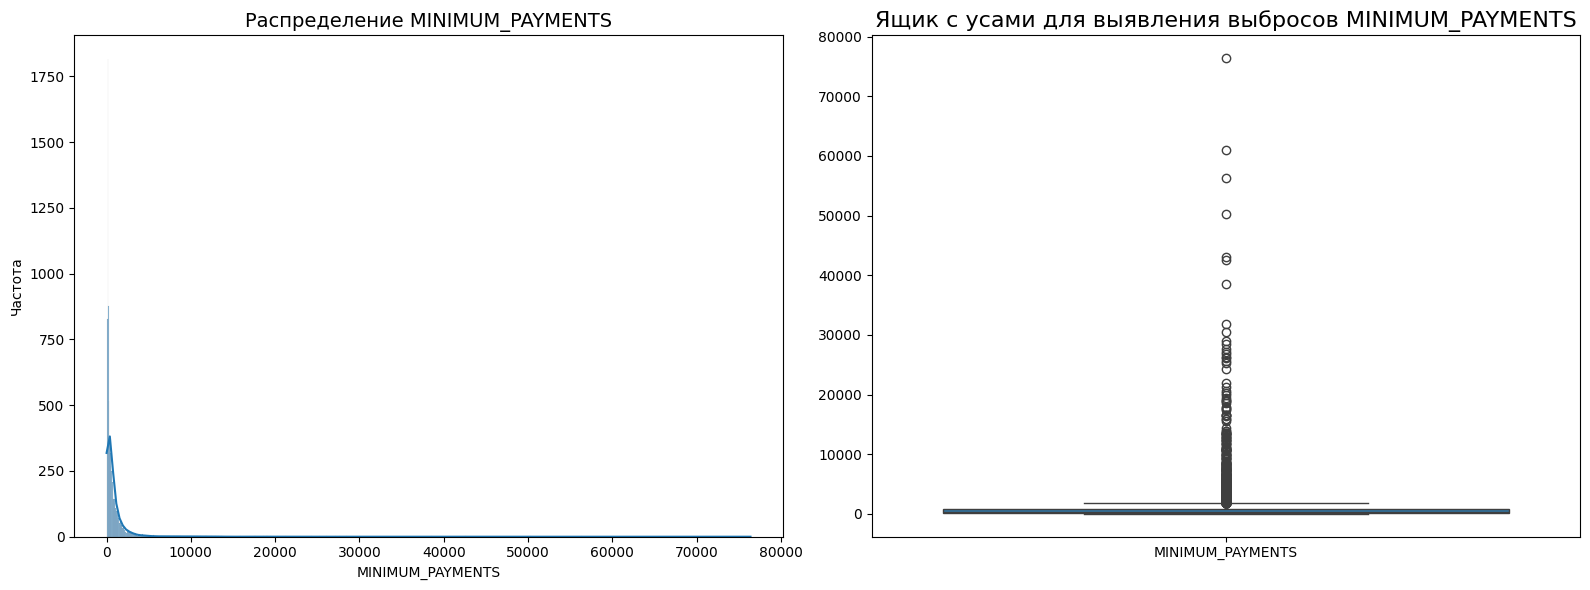

In [105]:
# анализируем колонку с MINIMUM_PAYMENTS пропущенными значениями
if df is not None:
    analyze_column(df, 'MINIMUM_PAYMENTS')

In [ ]:
'''
Есть пропущенные значения в колонке MINIMUM_PAYMENTS :  3.50%
Среднее: 864.21
Медиана (50%): 312.34
Стандартное отклонение: 2372.45 (очень большое, что говорит о широком разбросе данных)
Диапазон: от 0.019 до 76406.21

Учитывая экспоненциальное распределение и наличие выборос будем заполнять пропуски медианной
'''

In [106]:
# Обработка пропущенных значений (важно перед анализом выбросов)
# Заполнение пропущенных значений
if df is not None:
    column_to_analyze = 'MINIMUM_PAYMENTS'
    fill_gap_column(df, column_to_analyze)

Заполнение пропущенных значений...
--------------------------------------------------------------------------------
Анализ пропусков перед заполнением: MINIMUM_PAYMENTS
В столбце 'MINIMUM_PAYMENTS' содержится 313 пропущенных значений (NaN/Null).
Процент пропущенных значений: 3.50%
Анализ пропусков после заполнения: MINIMUM_PAYMENTS
В столбце 'MINIMUM_PAYMENTS' нет пропущенных значений.
--------------------------------------------------------------------------------
Заполнение пропусков завершено.


In [108]:
# Обнаружение выбросов с использованием IQR в MINIMUM_PAYMENTS
if df is not None:
    column_to_analyze = 'MINIMUM_PAYMENTS'
    detect_outliers_iqr(df, column_to_analyze)

Выбросы в столбце 'MINIMUM_PAYMENTS' (IQR):
     CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
5     C10006  1809.828751           1.000000    1333.28               0.0   
10    C10011  1293.124939           1.000000     920.12               0.0   
15    C10016  6886.213231           1.000000    1611.70               0.0   
19    C10020  3577.970933           1.000000     398.64               0.0   
20    C10021  2016.684686           1.000000     176.68               0.0   
...      ...          ...                ...        ...               ...   
8724  C18961  3002.791004           1.000000    2463.00            2463.0   
8754  C18993   455.471255           1.000000     389.70              44.7   
8840  C19081  2588.410789           0.888889     787.40               0.0   
8873  C19114  1023.883008           1.000000     585.84               0.0   
8881  C19122  2150.940844           1.000000    1105.74               0.0   

      INSTALLMENTS_PURCHASES  C

In [109]:
# Обнаружение выбросов с использованием Z-оценки
if df is not None:
    column_to_analyze = 'MINIMUM_PAYMENTS'
    detect_outliers_zscore(df, column_to_analyze)

Выбросы в столбце 'MINIMUM_PAYMENTS' (Z-оценка):
     CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
19    C10020  3577.970933           1.000000     398.64              0.00   
20    C10021  2016.684686           1.000000     176.68              0.00   
34    C10035  3517.101616           0.727273     547.28              0.00   
78    C10082  1205.716678           1.000000       0.00              0.00   
90    C10095  9381.255094           1.000000    5100.07           1147.83   
...      ...          ...                ...        ...               ...   
8274  C18495  1410.909779           1.000000     698.88              0.00   
8470  C18700  2046.727519           0.818182    1369.72            422.44   
8614  C18848  1182.080141           1.000000     266.68              0.00   
8688  C18925  2898.484109           1.000000       0.00              0.00   
8724  C18961  3002.791004           1.000000    2463.00           2463.00   

      INSTALLMENTS_PURCHAS

In [48]:
# удаление 909 выбросов (IQR) кажется слишком радикальным.
# выбросы не обрабатываем оставляем как есть

Анализ переменной CREDIT_LIMIT:
count     8949.000000
mean      4494.449450
std       3638.815725
min         50.000000
25%       1600.000000
50%       3000.000000
75%       6500.000000
max      30000.000000
Name: CREDIT_LIMIT, dtype: float64
В CREDIT_LIMIT содержится 1 пропущенных значений (NaN/Null).
В столбце 'CREDIT_LIMIT' содержится 1 пропущенных значений (NaN/Null).
Процент пропущенных значений: 0.01%


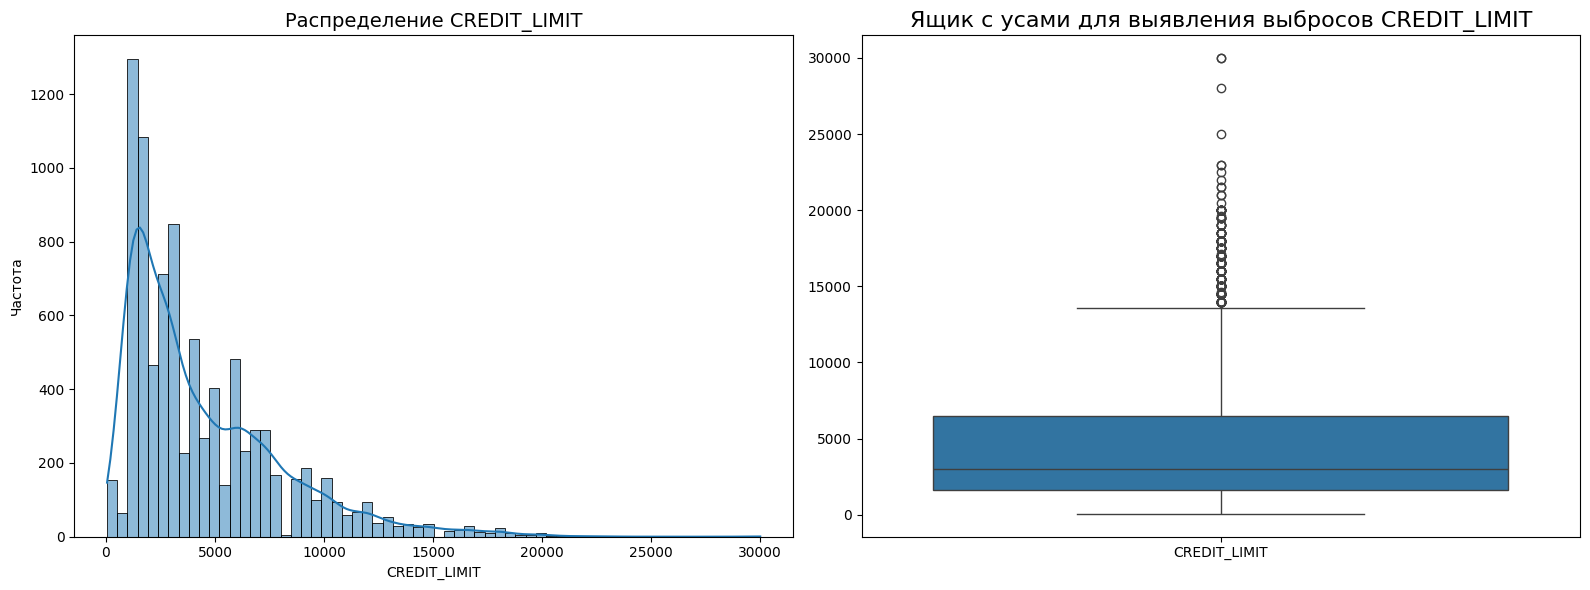

In [110]:
# пропущенные значения в CREDIT_LIMIT
if df is not None:
    analyze_column(df, 'CREDIT_LIMIT')

In [111]:
# Обработка пропущенных значений в CREDIT_LIMIT
# Заполнение пропущенных значений
if df is not None:
    column_to_analyze = 'CREDIT_LIMIT'
    fill_gap_column(df, column_to_analyze)

Заполнение пропущенных значений...
--------------------------------------------------------------------------------
Анализ пропусков перед заполнением: CREDIT_LIMIT
В столбце 'CREDIT_LIMIT' содержится 1 пропущенных значений (NaN/Null).
Процент пропущенных значений: 0.01%
Анализ пропусков после заполнения: CREDIT_LIMIT
В столбце 'CREDIT_LIMIT' нет пропущенных значений.
--------------------------------------------------------------------------------
Заполнение пропусков завершено.


In [112]:
# Обнаружение выбросов с использованием IQR в CREDIT_LIMIT
if df is not None:
    column_to_analyze = 'CREDIT_LIMIT'
    detect_outliers_iqr(df, column_to_analyze)

Выбросы в столбце 'CREDIT_LIMIT' (IQR):
     CUST_ID       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
85    C10089    134.917202           1.000000    1247.80           1247.80   
120   C10125   8504.876253           1.000000    6724.26           4100.08   
124   C10130  14224.115410           1.000000       0.00              0.00   
128   C10134  11167.234030           1.000000     150.64            150.64   
136   C10142   2494.868559           1.000000    5491.79           1390.50   
...      ...           ...                ...        ...               ...   
6629  C16812  16259.448570           1.000000    5024.68           3582.45   
7046  C17237   2980.054695           0.818182   26784.62          26514.32   
7764  C17975  10856.483010           1.000000      45.65             45.65   
7962  C18177  13318.659120           1.000000    3504.74           3266.29   
8229  C18450    161.926545           0.333333    1427.83           1427.83   

      INSTALLMENTS_PURC

In [113]:
# Обнаружение выбросов с использованием Z-оценки в CREDIT_LIMIT
if df is not None:
    column_to_analyze = 'CREDIT_LIMIT'
    detect_outliers_zscore(df, column_to_analyze)

Выбросы в столбце 'CREDIT_LIMIT' (Z-оценка):
     CUST_ID       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
85    C10089    134.917202           1.000000    1247.80           1247.80   
120   C10125   8504.876253           1.000000    6724.26           4100.08   
124   C10130  14224.115410           1.000000       0.00              0.00   
128   C10134  11167.234030           1.000000     150.64            150.64   
136   C10142   2494.868559           1.000000    5491.79           1390.50   
...      ...           ...                ...        ...               ...   
6433  C16609   6650.001408           1.000000     275.38            235.71   
6600  C16781   8465.296023           1.000000    1066.91            817.43   
6629  C16812  16259.448570           1.000000    5024.68           3582.45   
7046  C17237   2980.054695           0.818182   26784.62          26514.32   
7962  C18177  13318.659120           1.000000    3504.74           3266.29   

      INSTALLMENTS

In [114]:
# удаление 248 выбросов (IQR) кажется слишком радикальным.
# выбросы не обрабатываем оставляем как есть

In [115]:
if df is not None:
    # удаляем CUST_ID
    df = df.drop(columns=['CUST_ID'])
    df_shape(df)

Форма DataFrame:
(8950, 17)
--------------------------------------------------------------------------------


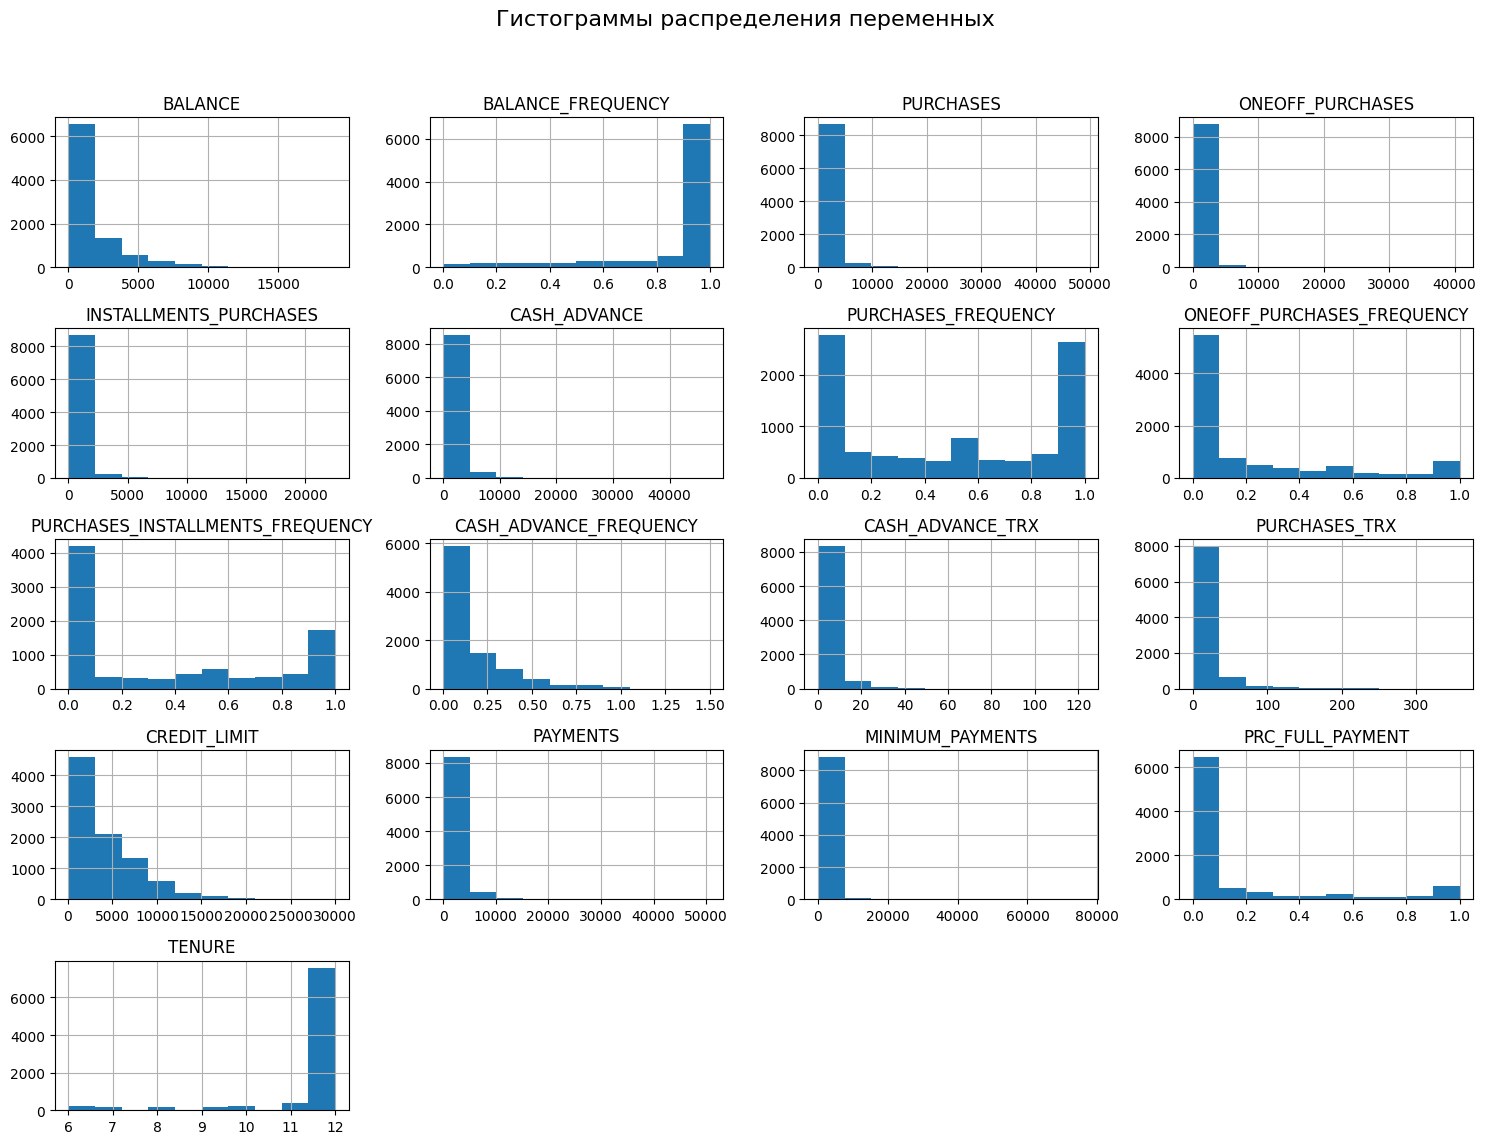

In [116]:
if df is not None:
    # Гистограммы для числовых переменных
    # Показывают распределение значений для каждой числовой переменной. Помогают увидеть, какие значения встречаются чаще всего.
    df.hist(figsize=(15, 12))
    plt.suptitle('Гистограммы распределения переменных', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

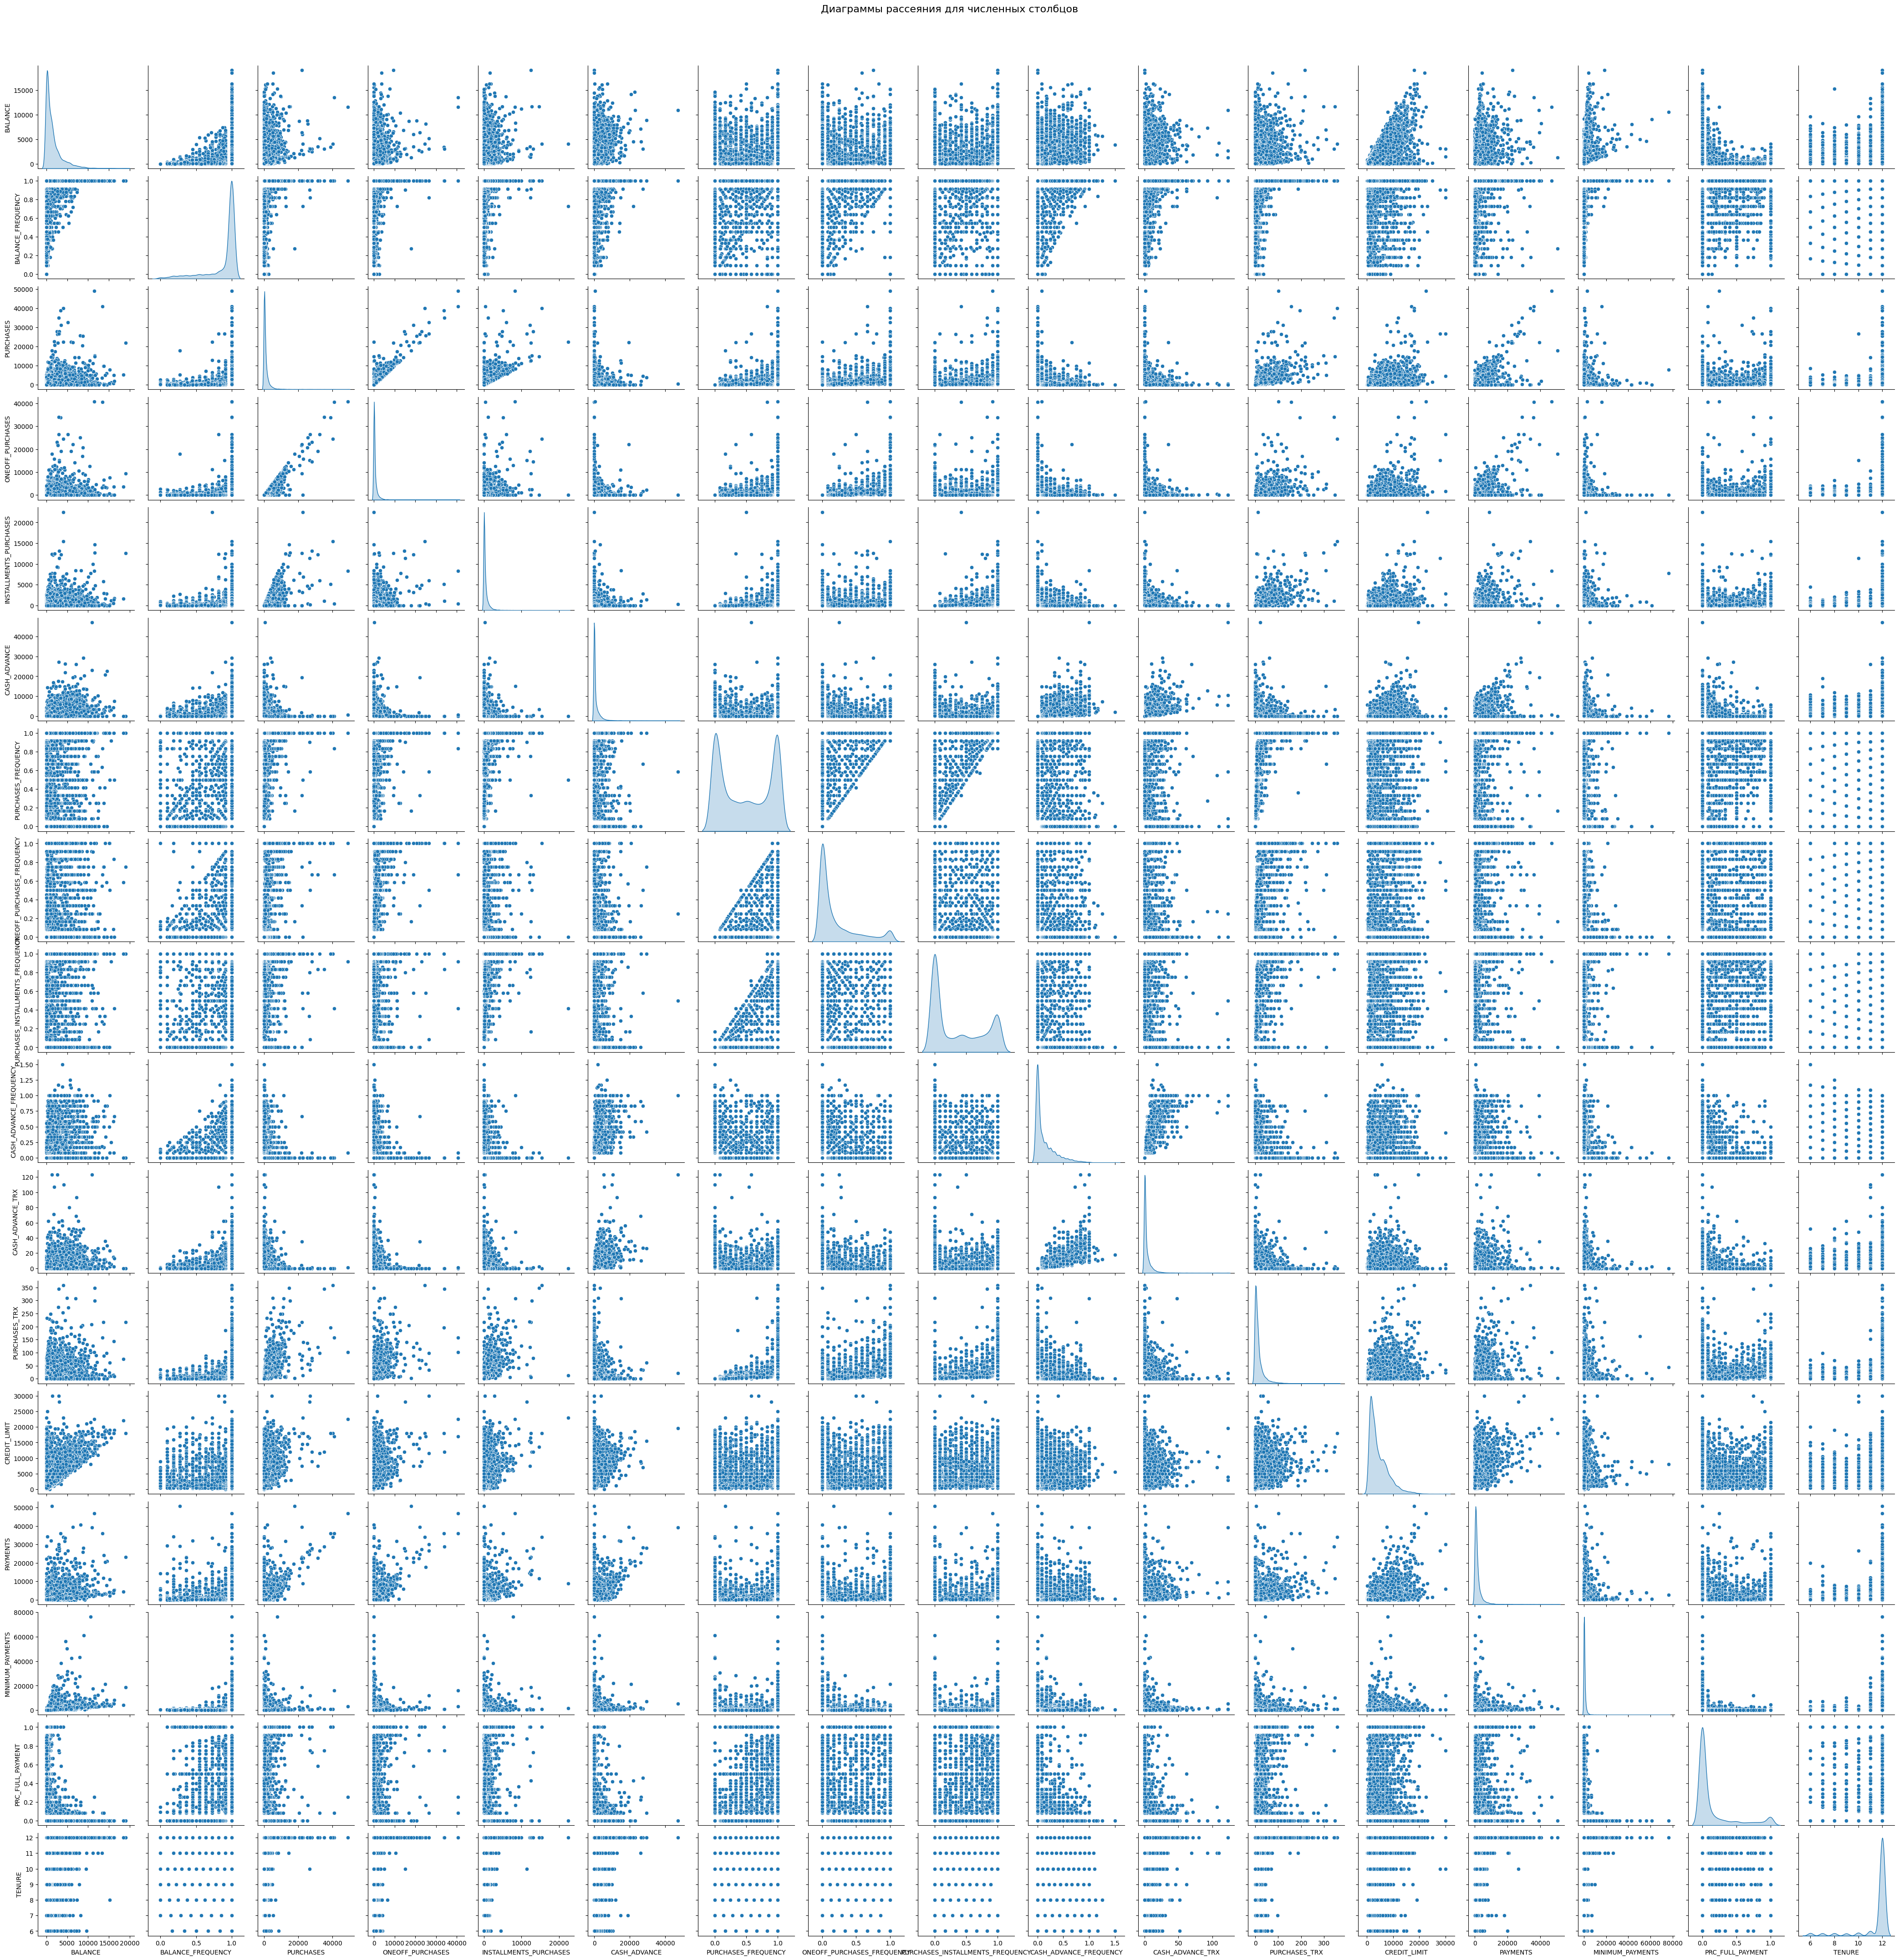

In [117]:
if df is not None:
    numeric_cols = df.select_dtypes(include=['number']).columns  # Выбираем только численные столбцы
    # Диаграммы рассеяния для выявления взаимосвязей
    # Диаграммы рассеяния: Показывают взаимосвязи между двумя переменными.
    # Если точки образуют какую-то закономерность (например, линию), это говорит о наличии связи.
    # dropna() используется, чтобы удалить строки с пропущенными значениями, иначе графики могут отображаться некорректно.
    if len(numeric_cols) >= 2:  # Нужно минимум два численных столбца
        sns.pairplot(df[numeric_cols].dropna(), diag_kind='kde') # kde - отображает плотность распределения на диагонали
        plt.suptitle('Диаграммы рассеяния для численных столбцов', fontsize=16, y=1.02) # y-position of title
        plt.show()

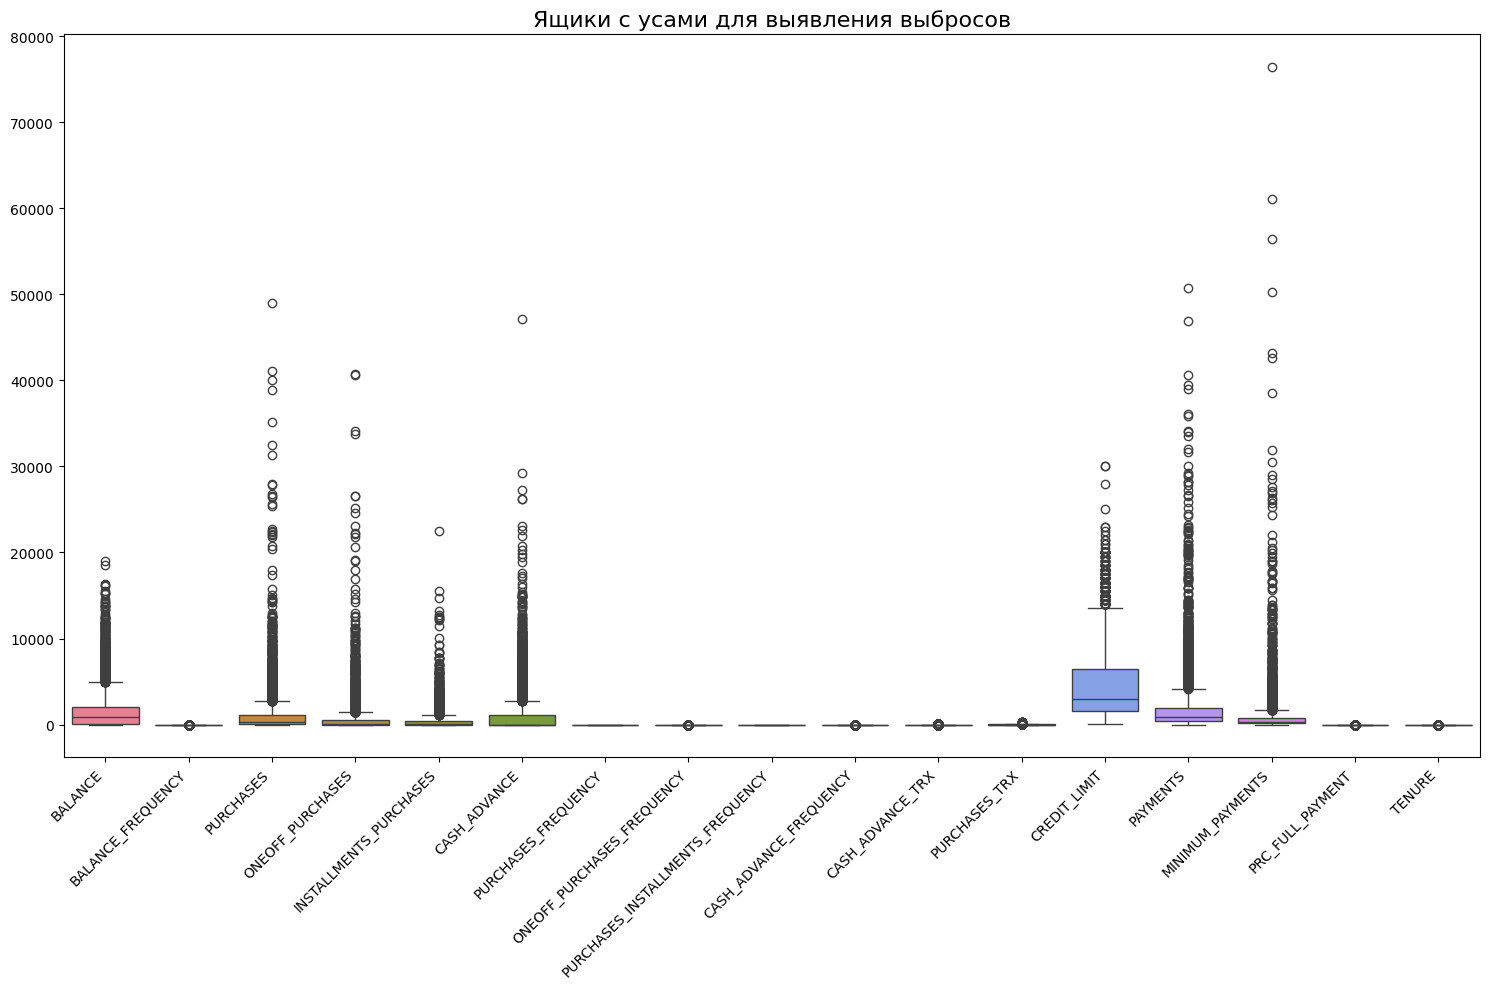

In [118]:
if df is not None:
    # Ящики с усами для выявления выбросов (для численных столбцов)
    # Показывают распределение данных, включая медиану, квартили и выбросы.
    numeric_cols = df.select_dtypes(include=['number']).columns  # Выбираем только численные столбцы
    if len(numeric_cols) > 0:  # Проверяем, что есть численные столбцы
        plt.figure(figsize=(15, 10))
        sns.boxplot(data=df[numeric_cols])
        plt.title('Ящики с усами для выявления выбросов', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

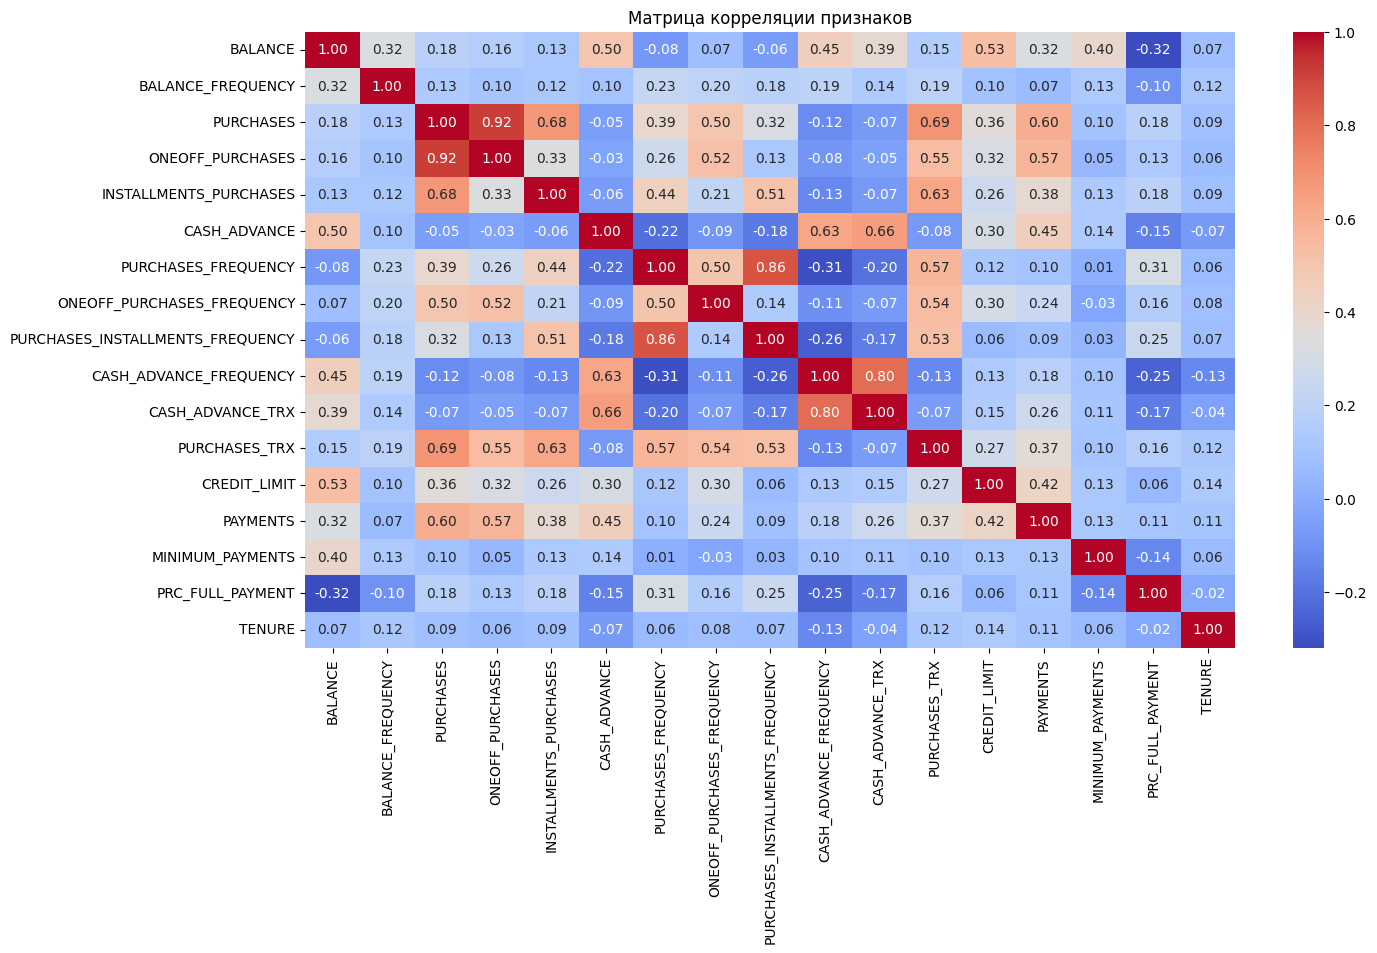

In [119]:
if df is not None:
    # Матрица корреляции
    # Показывает силу и направление линейной связи между всеми парами переменных. Значения от -1 до 1:
    # 1: Идеальная положительная корреляция (если одна переменная увеличивается, другая тоже увеличивается).
    # -1: Идеальная отрицательная корреляция (если одна переменная увеличивается, другая уменьшается).
    # 0: Отсутствие корреляции.
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Матрица корреляции признаков')
    plt.show()

In [120]:
# признак ONEOFF_PURCHASES коррелирует с PURCHASES
# признак CASH_ADVANCE_TRX коррелирует с CASH_ADVANCE_FREQUENCY
# удаляем ONEOFF_PURCHASES и CASH_ADVANCE_TRX
df = df.drop(columns=['ONEOFF_PURCHASES','CASH_ADVANCE_TRX'], axis=1)
df_shape(df)

Форма DataFrame:
(8950, 15)
--------------------------------------------------------------------------------


In [121]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [122]:
print(tf.__version__)

2.19.0


In [123]:
# Обучаем автоэнкодер сжимать информацию из 15 признаков в 3 новых признака.

# 1. Подготовка данных 
X = df.values  # Вытаскиваем значения из DataFrame

# Разделяем на обучающую и тестовую выборки
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Масштабируем данные  для лучшего обучения нейронной сети
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 2. Создаем и обучаем автоэнкодер.
# Параметры автоэнкодера
input_dim = X_train_scaled.shape[1]  # Должен быть равен 15
encoding_dim = 3  # Мы хотим извлечь 3 признака

# Создаем автоэнкодер
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

# Создаем модель
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем автоэнкодер
# Обучаем модель с использованием среднеквадратичной ошибки в качестве функции потер
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test_scaled, X_test_scaled))


# 3. Извлекаем признаки из тестовой выборки с помощью кодировщика.
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Извлекаем 3 признака
X_encoded = encoder_model.predict(X_test_scaled)


# 4. Сохраняем извлеченные признаки
features_df = pd.DataFrame(X_encoded, columns=['feature_1', 'feature_2', 'feature_3'])

# Теперь features_df содержит новые извлеченные признаки
print(features_df.head())

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2685 - val_loss: 1.1322
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0881 - val_loss: 0.9791
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9149 - val_loss: 0.9104
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9580 - val_loss: 0.8751
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8231 - val_loss: 0.8526
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8092 - val_loss: 0.8370
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7954 - val_loss: 0.8245
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7933 - val_loss: 0.8145
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7797 - val_loss: 0.8066
Epoch 10/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8145 - val_loss: 0.8000
Epoch 11/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7777 - val_loss: 0.7942
Epoch 12/100
224/224 ━━━━━━━━━━━━━━━━━━━━

Первые 5 строк DataFrame:
   feature_1  feature_2  feature_3
0   4.482610   5.124578   8.068127
1   4.688567   3.763238   5.079611
2   4.154768   8.226196   2.795206
3   2.342651   2.663918   3.606760
4   3.711246   3.977402   0.023785
--------------------------------------------------------------------------------
Форма DataFrame:
(1790, 3)
--------------------------------------------------------------------------------
Типы данных колонок:
feature_1    float32
feature_2    float32
feature_3    float32
dtype: object
------------------------------
Описание значений колонок:
Колонка: feature_1
count    1790.000000
mean        4.745805
std         3.514054
min         0.000000
25%         2.414463
50%         4.710666
75%         6.581854
max        37.294598
Name: feature_1, dtype: float64
---------------
Колонка: feature_2
count    1790.000000
mean        4.565393
std         2.594634
min         0.000000
25%         2.652109
50%         4.517495
75%         6.552481
max        20.6700

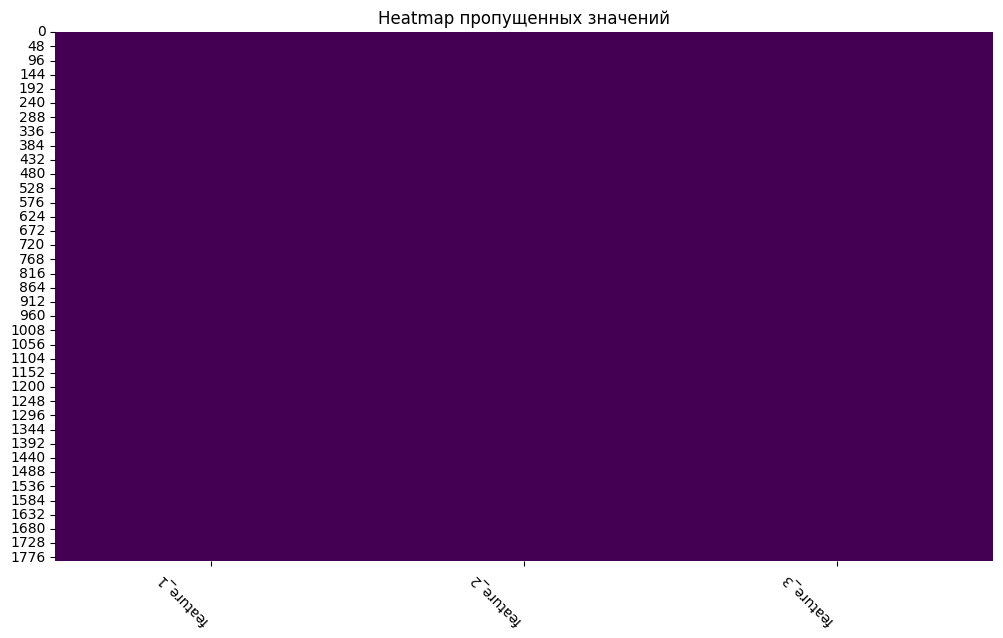

In [124]:
# Разведочный анализ данных features_df EDA (Exploratory Data Analysis)
# Первичный анализ данных
if features_df is not None:
    # Первые 5 строк DataFrame:
    df_head_5(features_df)

    # Форма DataFrame:
    df_shape(features_df)
    
    # Описывает типы данных и значения колонок DataFrame.
    describe_dataframe_columns(features_df)    
    
    # Проверка на дубликаты:
    check_duplicates(features_df)
    
    # Проверка на пропущенные значения:
    check_missing_values(features_df)
    
    #Визуализирует пропущенные значения в DataFrame с помощью тепловой карты.
    visualize_missing_values(features_df)
else:
    print("DataFrame 'features_df' не определен. Пожалуйста, загрузите данные в DataFrame.")

In [125]:
# Функция для снижения размерности с помощью PCA
def reduce_dimensions(X_scaled, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca

def get_X_scaled(X_encoded):
    features_df = pd.DataFrame(X_encoded, columns=['feature_1', 'feature_2', 'feature_3'])
    # Масштабирование данных
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_df.values)
    return X_scaled

def print_scores(n_clusters, silhouette_avg, davies_bouldin, calinski_harabasz, inertia):
    if n_clusters is not None:
        print(f"Количество кластеров: {n_clusters}")
    if silhouette_avg is not None:
        print(f"Силуэтная оценка: {silhouette_avg:.2f}")
    if davies_bouldin is not None:
        print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
    if calinski_harabasz is not None:
        print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")
    if inertia is not None:
        print(f"Инерция: {inertia:.2f}")
    print_splitter()

# Функция для визуализации кластеров
def visualize_clusters(X_pca, labels, title="Агломеративная кластеризация"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
    plt.title(title)
    plt.xlabel("Первая главная компонента")
    plt.ylabel("Вторая главная компонента")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.colorbar()
    plt.show()

def visualize_clusters_with_centers(X_pca, predicted_labels, cluster_centers_pca, title="Mean Shift Clustering"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis', marker='o', s=70, alpha=0.7, label='Объекты')
    plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', marker='X', s=250, label='Центры кластеров')
    plt.title(title)
    plt.xlabel('Первая главная компонента')
    plt.ylabel('Вторая главная компонента')
    plt.legend(fontsize='large')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.colorbar()
    plt.show()

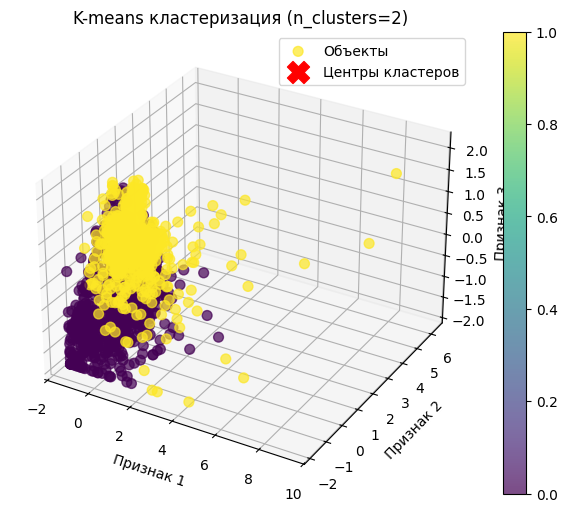

Количество кластеров: 2
Силуэтная оценка: 0.35
Индекс Дэвиса-Болдуина: 1.21
Индекс Калински-Харабаса: 929.27
Инерция: 3533.53
--------------------------------------------------------------------------------


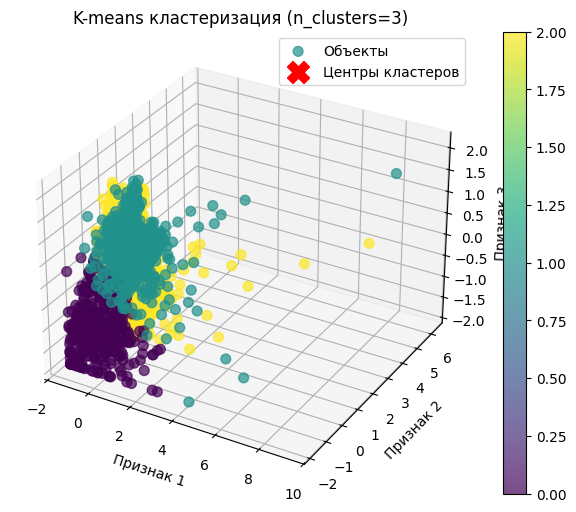

Количество кластеров: 3
Силуэтная оценка: 0.38
Индекс Дэвиса-Болдуина: 0.98
Индекс Калински-Харабаса: 980.43
Инерция: 2560.45
--------------------------------------------------------------------------------


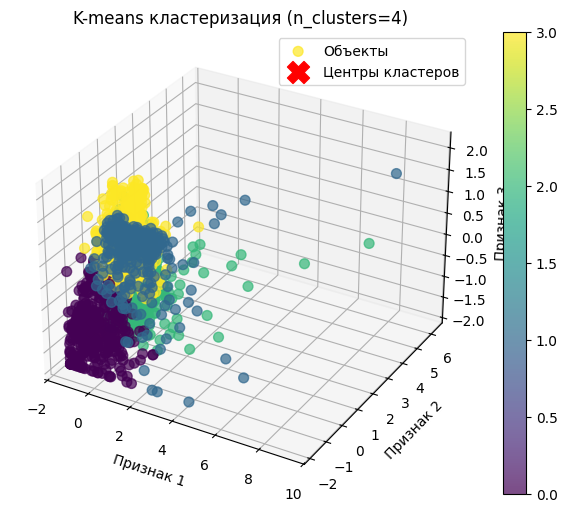

Количество кластеров: 4
Силуэтная оценка: 0.33
Индекс Дэвиса-Болдуина: 1.07
Индекс Калински-Харабаса: 916.53
Инерция: 2114.58
--------------------------------------------------------------------------------


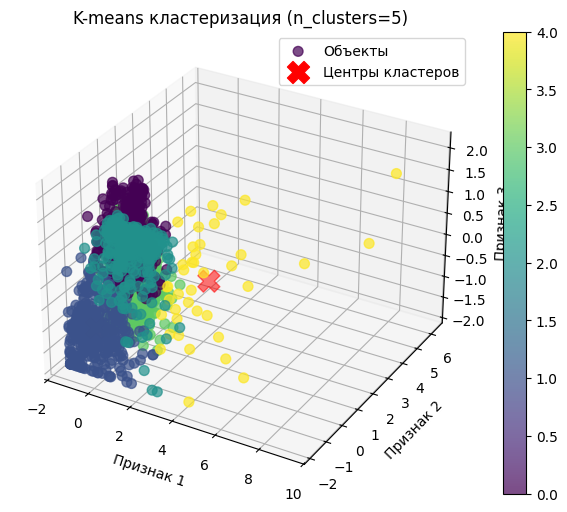

Количество кластеров: 5
Силуэтная оценка: 0.33
Индекс Дэвиса-Болдуина: 1.00
Индекс Калински-Харабаса: 863.62
Инерция: 1829.46
--------------------------------------------------------------------------------


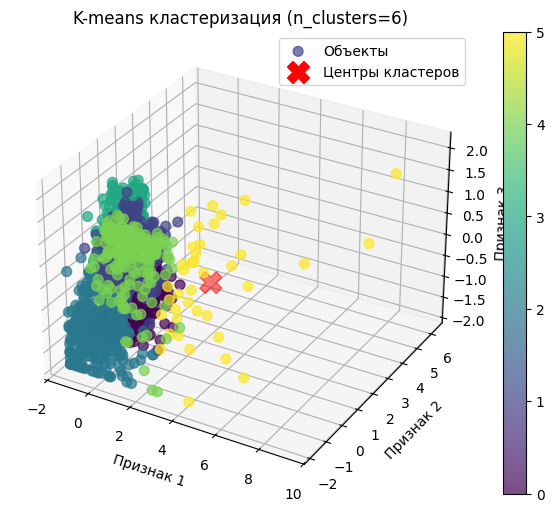

Количество кластеров: 6
Силуэтная оценка: 0.33
Индекс Дэвиса-Болдуина: 1.02
Индекс Калински-Харабаса: 823.57
Инерция: 1623.24
--------------------------------------------------------------------------------


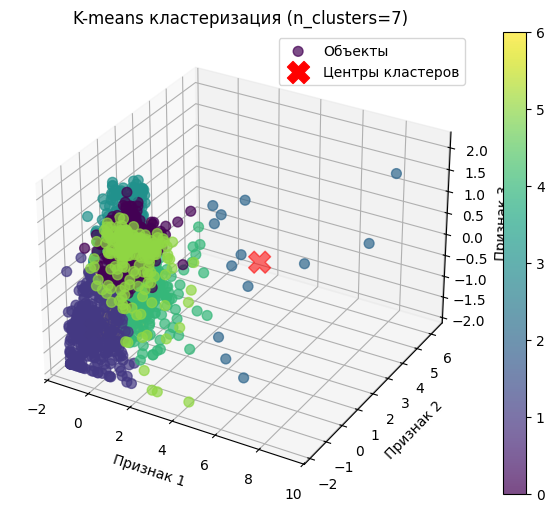

Количество кластеров: 7
Силуэтная оценка: 0.33
Индекс Дэвиса-Болдуина: 1.01
Индекс Калински-Харабаса: 802.17
Инерция: 1451.59
--------------------------------------------------------------------------------


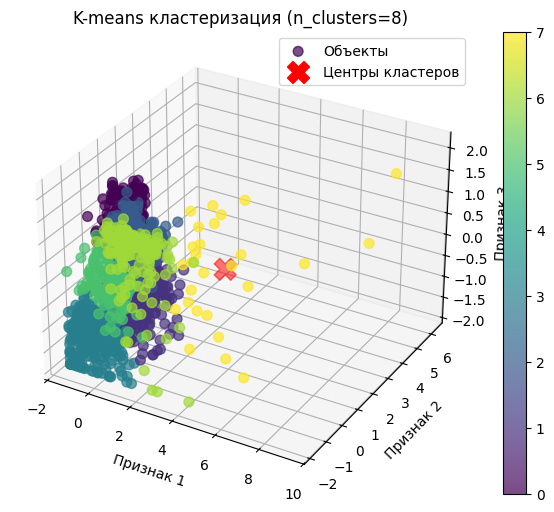

Количество кластеров: 8
Силуэтная оценка: 0.32
Индекс Дэвиса-Болдуина: 1.00
Индекс Калински-Харабаса: 781.69
Инерция: 1319.21
--------------------------------------------------------------------------------


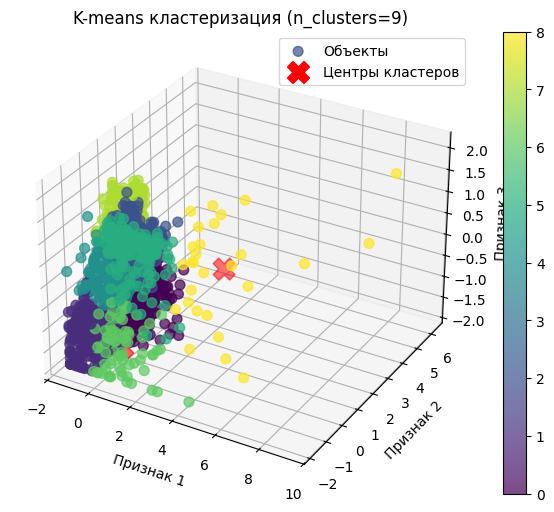

Количество кластеров: 9
Силуэтная оценка: 0.33
Индекс Дэвиса-Болдуина: 0.99
Индекс Калински-Харабаса: 770.98
Инерция: 1203.19
--------------------------------------------------------------------------------


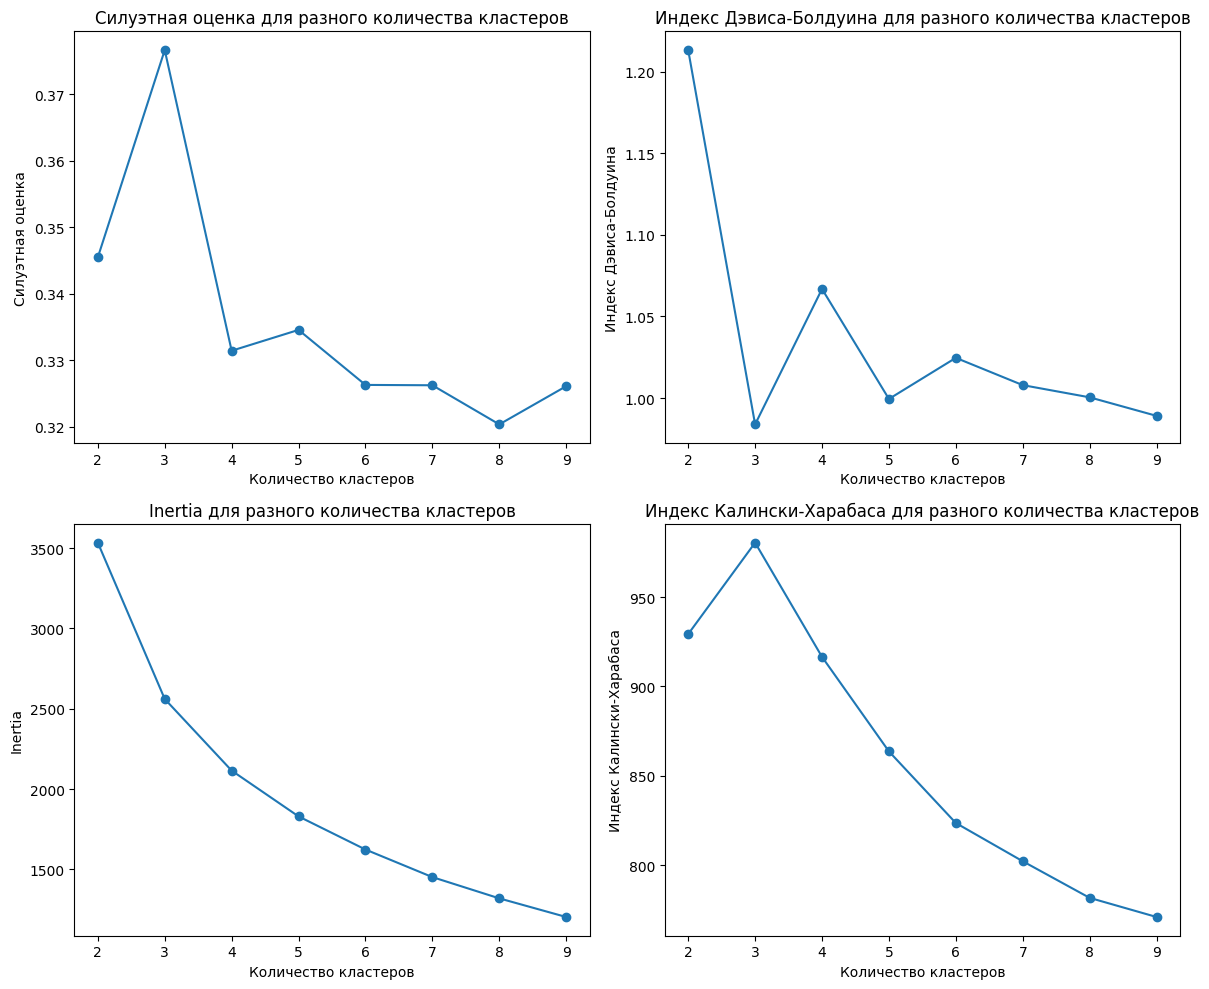

In [126]:
#Кластеризация по методу K-Means для 3 признаков с 3D визуализацией
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Функция для оценки кластеризации и визуализации
def evaluate_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # Вычисление метрик
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    inertia = kmeans.inertia_
    calinski_harabasz = calinski_harabasz_score(X, labels)

    # 3D визуализация
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, s=50, cmap='viridis', marker='o', alpha=0.7, label='Объекты')


    # Отображение центроидов
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=250, marker='X', label='Центры кластеров')

    # Подписи осей и заголовок
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')
    ax.set_zlabel('Признак 3')
    ax.set_title(f'K-means кластеризация (n_clusters={n_clusters})')
    plt.legend()  # Показать легенду для центроидов
    fig.colorbar(scatter, ax=ax)  # Добавить цветовую шкалу
    plt.show()

    print_scores(n_clusters, silhouette_avg, davies_bouldin, calinski_harabasz, inertia)

    return {
        'silhouette': silhouette_avg,
        'davies_bouldin': davies_bouldin,
        'inertia': inertia,
        'calinski_harabasz': calinski_harabasz
    }


# Основной цикл: перебор количества кластеров
results = {}
X_scaled = get_X_scaled(X_encoded)
for n_clusters in range(2, 10):
    results[n_clusters] = evaluate_clustering(X_scaled, n_clusters)


# Визуализация изменений метрик (после цикла)
plt.figure(figsize=(12, 10))

# Силуэтная оценка
plt.subplot(2, 2, 1)
plt.plot(results.keys(), [v['silhouette'] for v in results.values()], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтная оценка')
plt.title('Силуэтная оценка для разного количества кластеров')

# Индекс Дэвиса-Болдуина
plt.subplot(2, 2, 2)
plt.plot(results.keys(), [v['davies_bouldin'] for v in results.values()], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс Дэвиса-Болдуина')
plt.title('Индекс Дэвиса-Болдуина для разного количества кластеров')

# Inertia
plt.subplot(2, 2, 3)
plt.plot(results.keys(), [v['inertia'] for v in results.values()], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Inertia для разного количества кластеров')

# Индекс Калински-Харабаса
plt.subplot(2, 2, 4)
plt.plot(results.keys(), [v['calinski_harabasz'] for v in results.values()], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс Калински-Харабаса')
plt.title('Индекс Калински-Харабаса для разного количества кластеров')

plt.tight_layout()
plt.show()

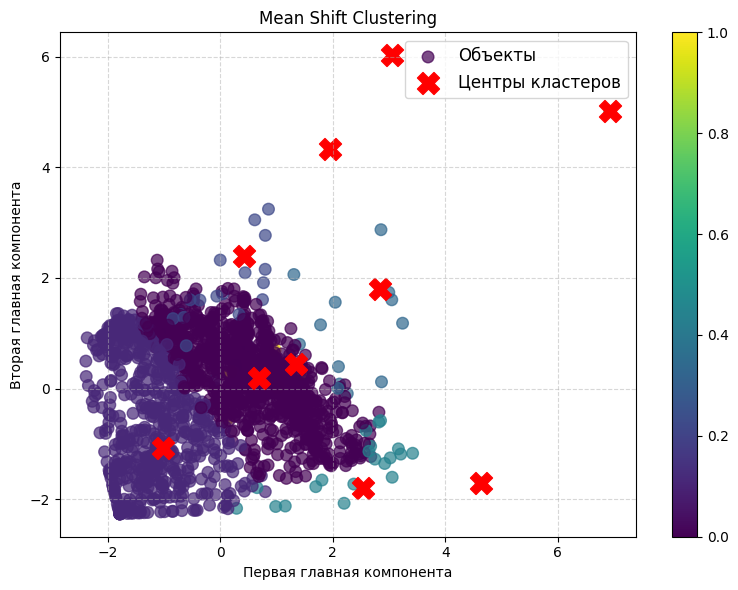

Силуэтная оценка: 0.28
Индекс Дэвиса-Болдуина: 0.76
Индекс Калински-Харабаса: 151.19
--------------------------------------------------------------------------------


In [127]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


# --- Оценка bandwidth и кластеризация Mean Shift ---
def perform_mean_shift(X_scaled, quantile=0.2, n_samples=500):
    # Оценка bandwidth
    bandwidth = estimate_bandwidth(X_scaled, quantile=quantile, n_samples=n_samples)

    # Кластеризация Mean Shift
    mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    mean_shift.fit(X_scaled)
    predicted_labels = mean_shift.labels_
    cluster_centers = mean_shift.cluster_centers_

    return predicted_labels, cluster_centers, bandwidth


# --- Оценка качества кластеризации ---
def evaluate_clustering(X_scaled, predicted_labels):
    silhouette_avg = silhouette_score(X_scaled, predicted_labels)
    davies_bouldin = davies_bouldin_score(X_scaled, predicted_labels)
    calinski_harabasz = calinski_harabasz_score(X_scaled, predicted_labels)
    return silhouette_avg, davies_bouldin, calinski_harabasz


# 1. Подготовка данных и масштабирование данных
X_scaled = get_X_scaled(X_encoded)

# 2. Кластеризация Mean Shift
predicted_labels, cluster_centers, bandwidth = perform_mean_shift(X_scaled)

# 3. Снижение размерности и визуализация
X_pca, pca = reduce_dimensions(X_scaled)
cluster_centers_pca = pca.transform(cluster_centers)
visualize_clusters_with_centers(X_pca, predicted_labels, cluster_centers_pca, 'Mean Shift Clustering')

# 4. Оценка качества кластеризации
silhouette_avg, davies_bouldin, calinski_harabasz = evaluate_clustering(X_scaled, predicted_labels)
print_scores(None, silhouette_avg, davies_bouldin, calinski_harabasz, None)

Количество кластеров: 68
Кластер 1 - Центр: [ 0.37282348 -1.4696925  -0.10320739], Количество объектов: 19
Кластер 2 - Центр: [-0.38048106  0.62416047 -0.23811696], Количество объектов: 45
Кластер 3 - Центр: [0.02051731 3.855857   5.8368382 ], Количество объектов: 1
Кластер 4 - Центр: [ 3.4024463  3.7950082 10.060049 ], Количество объектов: 1
Кластер 5 - Центр: [-0.54111016 -1.0452652   0.9029364 ], Количество объектов: 14
Кластер 6 - Центр: [ 0.6760889  -0.75474656  0.5484158 ], Количество объектов: 25
Кластер 7 - Центр: [ 1.2442936 -0.4610418  1.8745962], Количество объектов: 20
Кластер 8 - Центр: [ 1.4524302  -1.857331   -0.02339167], Количество объектов: 8
Кластер 9 - Центр: [-0.03762387  0.78490585  0.28097826], Количество объектов: 41
Кластер 10 - Центр: [ 0.55310494 -1.5594983   1.2099683 ], Количество объектов: 11
Кластер 11 - Центр: [-1.5620804 -1.9128537 -1.1830233], Количество объектов: 40
Кластер 12 - Центр: [0.38811323 5.658328   8.1153555 ], Количество объектов: 1
Кластер

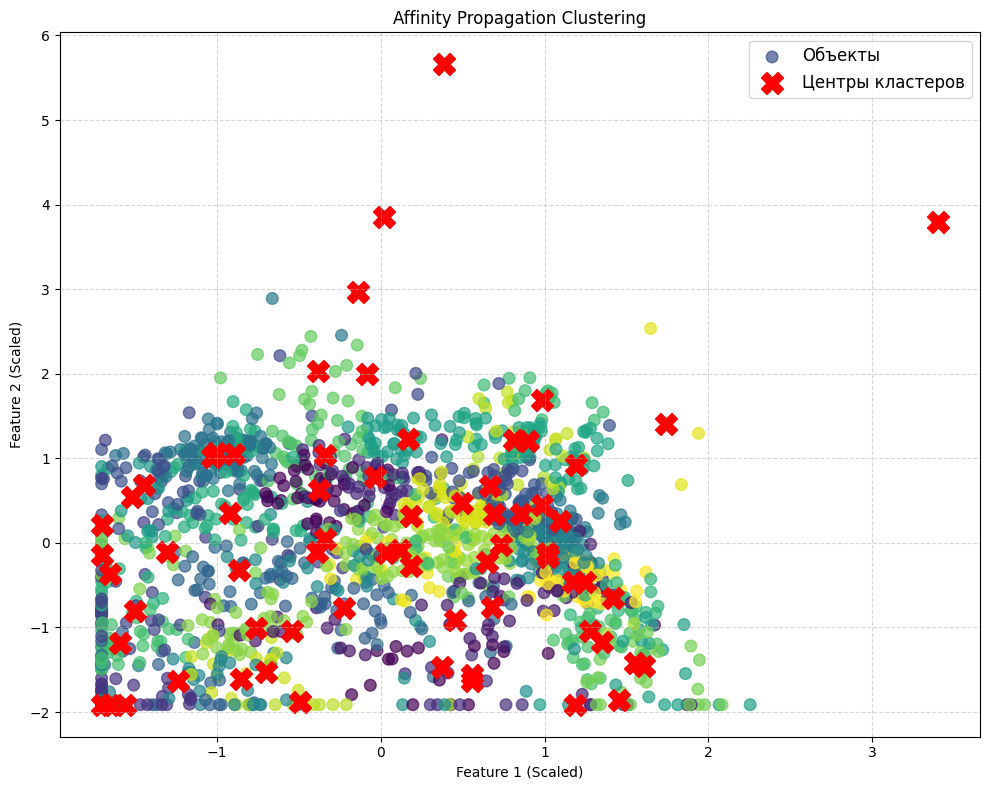

Силуэтная оценка: 0.28
Индекс Дэвиса-Болдуина: 0.89
Индекс Калински-Харабаса: 546.42
--------------------------------------------------------------------------------


In [74]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 1. Подготовка данных и масштабирование данных
X_scaled = get_X_scaled(X_encoded)


# 2. Кластеризация с использованием Affinity Propagation ---
# 2.1. Инициализация и обучение модели
af = AffinityPropagation(random_state=42)
af.fit(X_scaled)

# 2.2. Получение результатов
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)


# 3. Анализ результатов
# 3.1. Вывод информации о кластерах
print(f"Количество кластеров: {n_clusters_}")

for i in range(n_clusters_):
    cluster_center = X_scaled[cluster_centers_indices[i]]
    cluster_objects = X_scaled[labels == i]
    print(f"Кластер {i + 1} - Центр: {cluster_center}, Количество объектов: {len(cluster_objects)}")

# 3.2. Визуализация кластеров (с использованием первых двух признаков)
plt.figure(figsize=(10, 8))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', marker='o', s=70, alpha=0.7, label='Объекты')
plt.scatter(X_scaled[cluster_centers_indices, 0], X_scaled[cluster_centers_indices, 1], c='red', marker='X', s=250, label='Центры кластеров')
plt.title('Affinity Propagation Clustering')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend(fontsize='large')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# 4. Оценка качества кластеризации
# 4.1. Вычисление метрик
silhouette_avg = silhouette_score(X_scaled, labels)
davies_bouldin = davies_bouldin_score(X_scaled, labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, labels)

# 4.2. Вывод метрик
print_scores(None, silhouette_avg, davies_bouldin, calinski_harabasz, None)

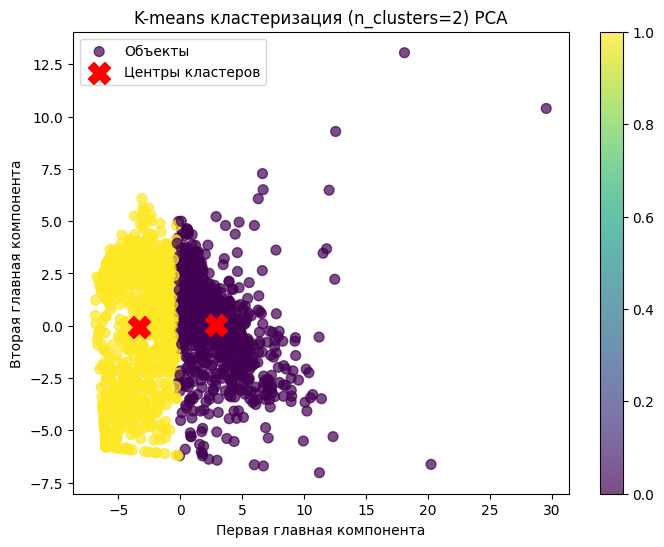

Количество кластеров: 2
Силуэтная оценка: 0.41
Индекс Дэвиса-Болдуина: 0.95
Индекс Калински-Харабаса: 1454.93
Инерция: 21148.93
--------------------------------------------------------------------------------


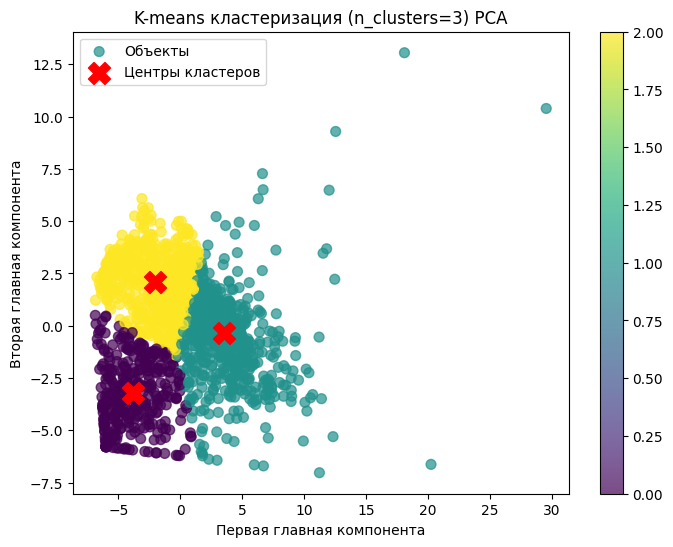

Количество кластеров: 3
Силуэтная оценка: 0.42
Индекс Дэвиса-Болдуина: 0.81
Индекс Калински-Харабаса: 1481.26
Инерция: 14432.20
--------------------------------------------------------------------------------


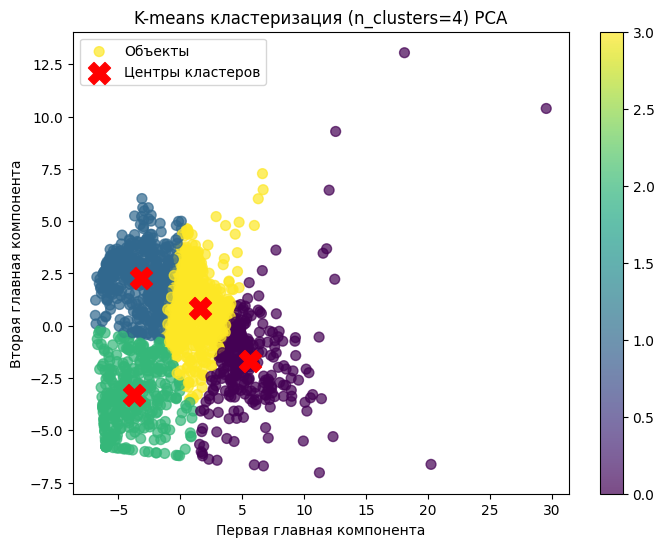

Количество кластеров: 4
Силуэтная оценка: 0.40
Индекс Дэвиса-Болдуина: 0.84
Индекс Калински-Харабаса: 1517.68
Инерция: 10807.29
--------------------------------------------------------------------------------


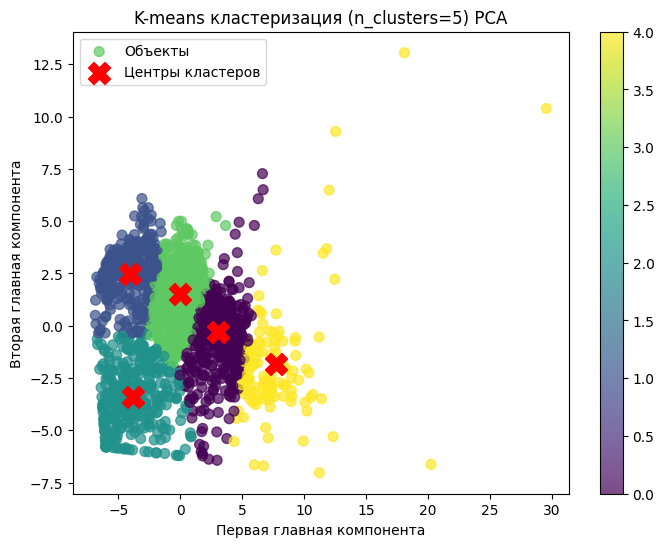

Количество кластеров: 5
Силуэтная оценка: 0.38
Индекс Дэвиса-Болдуина: 0.86
Индекс Калински-Харабаса: 1444.17
Инерция: 9054.77
--------------------------------------------------------------------------------


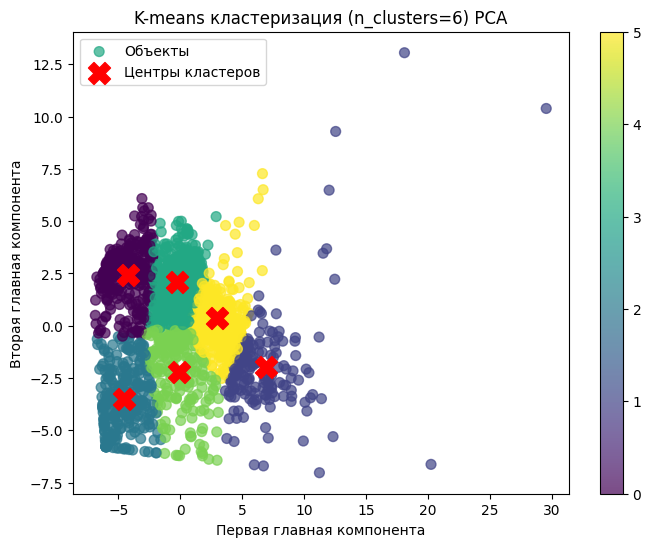

Количество кластеров: 6
Силуэтная оценка: 0.39
Индекс Дэвиса-Болдуина: 0.83
Индекс Калински-Харабаса: 1425.16
Инерция: 7680.42
--------------------------------------------------------------------------------


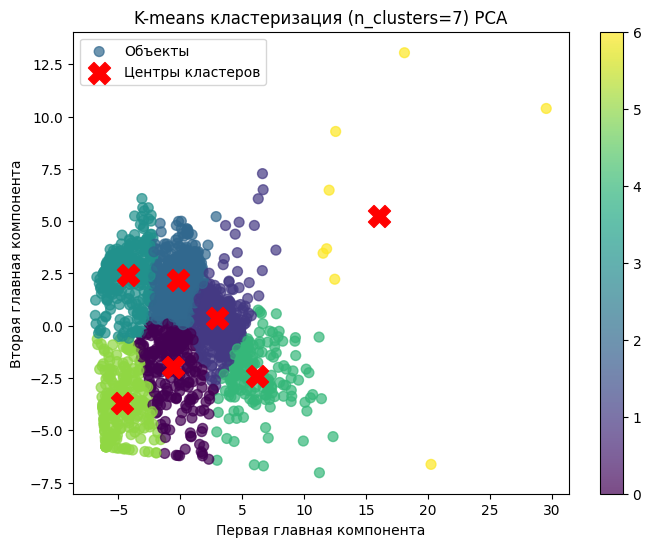

Количество кластеров: 7
Силуэтная оценка: 0.39
Индекс Дэвиса-Болдуина: 0.80
Индекс Калински-Харабаса: 1450.36
Инерция: 6523.57
--------------------------------------------------------------------------------


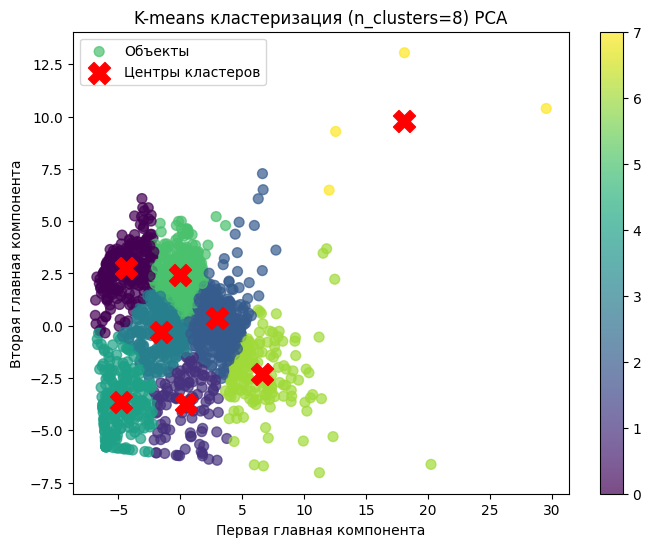

Количество кластеров: 8
Силуэтная оценка: 0.40
Индекс Дэвиса-Болдуина: 0.77
Индекс Калински-Харабаса: 1423.64
Инерция: 5818.62
--------------------------------------------------------------------------------


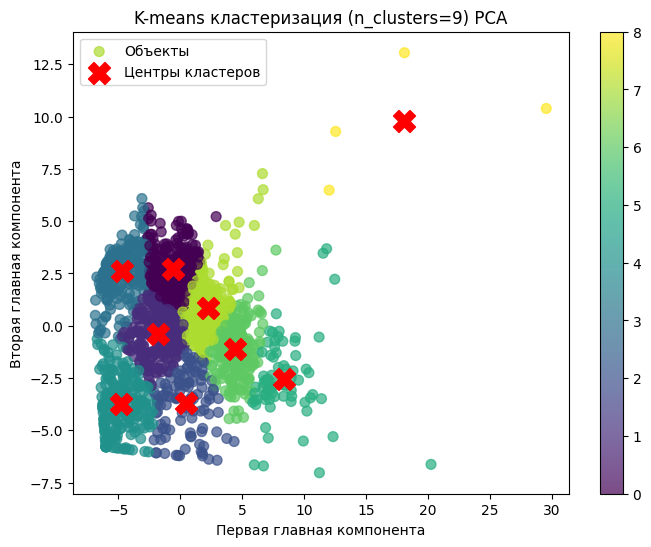

Количество кластеров: 9
Силуэтная оценка: 0.38
Индекс Дэвиса-Болдуина: 0.79
Индекс Калински-Харабаса: 1434.21
Инерция: 5154.10
--------------------------------------------------------------------------------


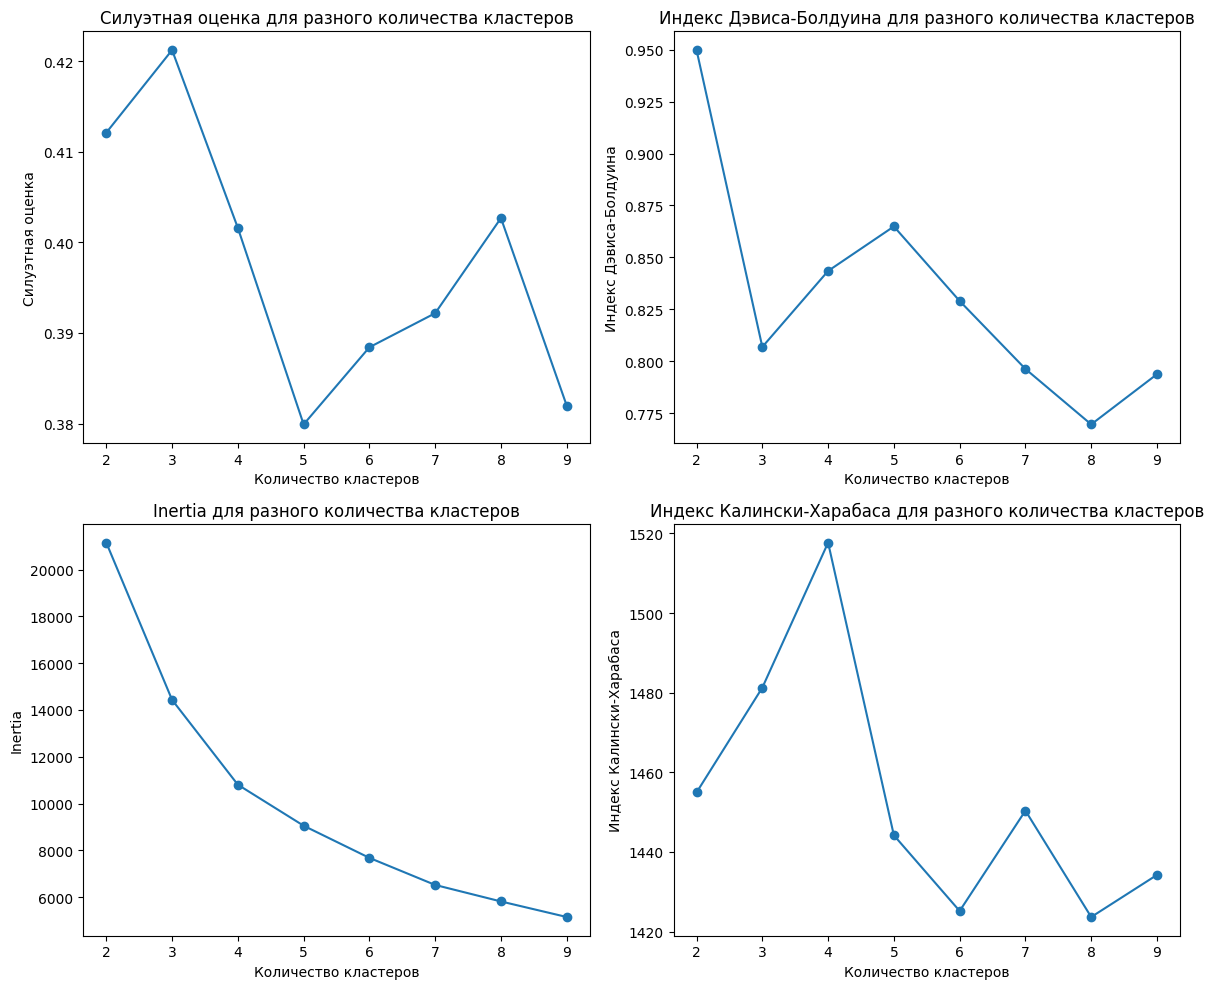

In [128]:
#Кластеризация по методу K-Means для 3 признаков с 2D визуализацией

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import pandas as pd 

# Функция для оценки кластеризации и визуализации
def evaluate_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # Вычисление метрик
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    inertia = kmeans.inertia_
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    # визуализация
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', marker='o', alpha=0.7, label='Объекты')


    # Отображение центроидов
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, marker='X', label='Центры кластеров')

    # Подписи осей и заголовок
    plt.xlabel('Первая главная компонента')
    plt.ylabel('Вторая главная компонента')
    plt.title(f'K-means кластеризация (n_clusters={n_clusters}) PCA')
    plt.legend()  # Показать легенду для центроидов
    plt.colorbar(scatter)  # Добавить цветовую шкалу
    plt.show()

    print_scores(n_clusters, silhouette_avg, davies_bouldin, calinski_harabasz, inertia)

    return {
        'silhouette': silhouette_avg,
        'davies_bouldin': davies_bouldin,
        'inertia': inertia,
        'calinski_harabasz': calinski_harabasz
    }


# Основной цикл: перебор количества кластеров
results = {}
X_pca, pca = reduce_dimensions(features_df)
for n_clusters in range(2, 10):
    results[n_clusters] = evaluate_clustering(X_pca, n_clusters)


# Визуализация изменений метрик (после цикла)
plt.figure(figsize=(12, 10))

# Силуэтная оценка
plt.subplot(2, 2, 1)
plt.plot(results.keys(), [v['silhouette'] for v in results.values()], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтная оценка')
plt.title('Силуэтная оценка для разного количества кластеров')

# Индекс Дэвиса-Болдуина
plt.subplot(2, 2, 2)
plt.plot(results.keys(), [v['davies_bouldin'] for v in results.values()], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс Дэвиса-Болдуина')
plt.title('Индекс Дэвиса-Болдуина для разного количества кластеров')

# Inertia
plt.subplot(2, 2, 3)
plt.plot(results.keys(), [v['inertia'] for v in results.values()], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Inertia для разного количества кластеров')

# Индекс Калински-Харабаса
plt.subplot(2, 2, 4)
plt.plot(results.keys(), [v['calinski_harabasz'] for v in results.values()], marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс Калински-Харабаса')
plt.title('Индекс Калински-Харабаса для разного количества кластеров')

plt.tight_layout()
plt.show()

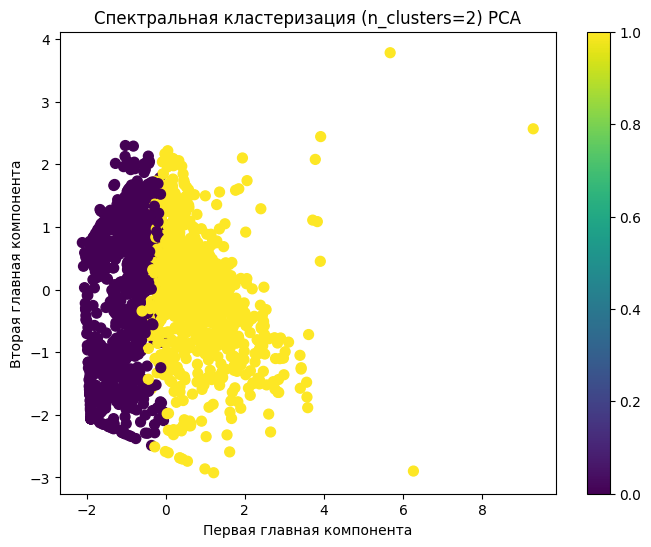

Количество кластеров: 2
Силуэтная оценка: 0.31
Индекс Дэвиса-Болдуина: 1.34
Индекс Калински-Харабаса: 739.70
--------------------------------------------------------------------------------


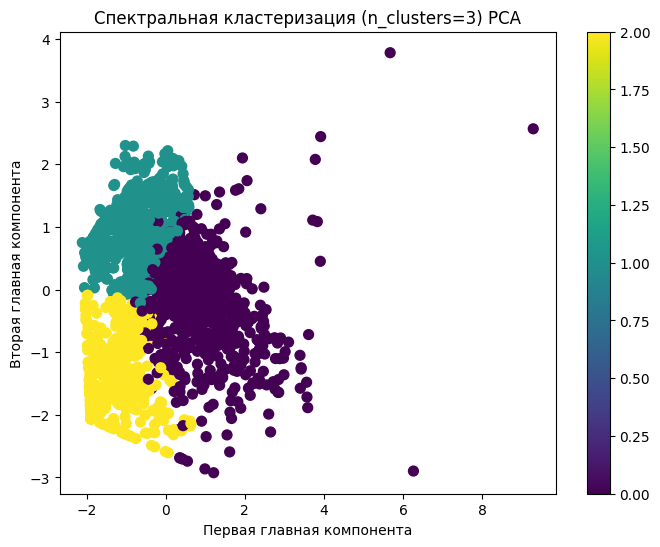

Количество кластеров: 3
Силуэтная оценка: 0.32
Индекс Дэвиса-Болдуина: 1.05
Индекс Калински-Харабаса: 799.26
--------------------------------------------------------------------------------


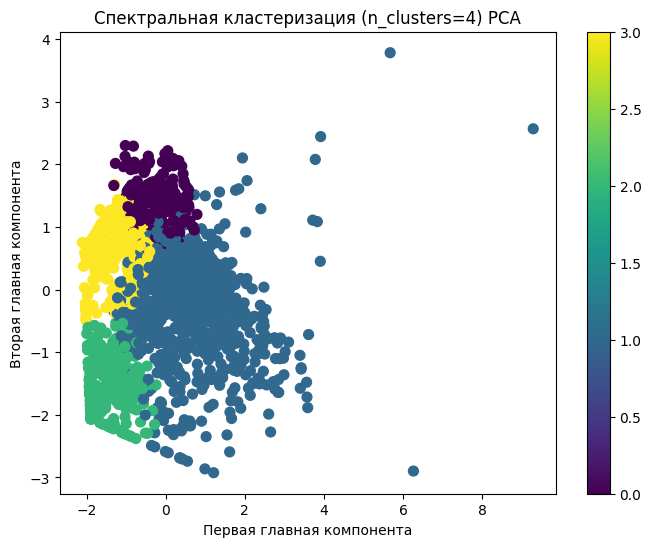

Количество кластеров: 4
Силуэтная оценка: 0.23
Индекс Дэвиса-Болдуина: 0.98
Индекс Калински-Харабаса: 540.89
--------------------------------------------------------------------------------


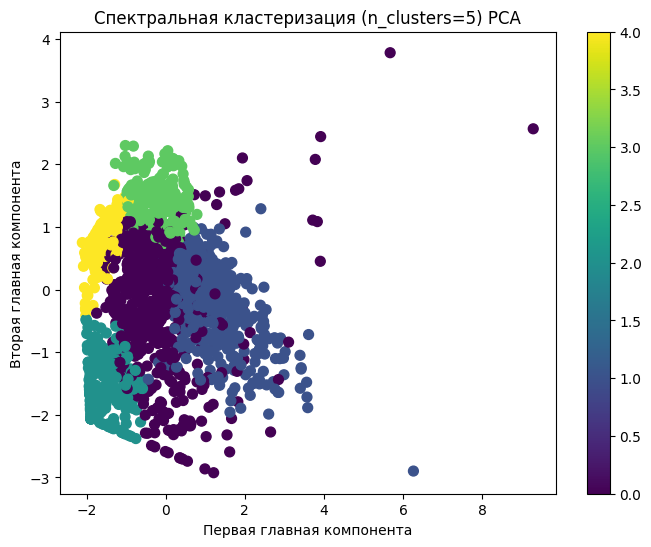

Количество кластеров: 5
Силуэтная оценка: 0.23
Индекс Дэвиса-Болдуина: 1.16
Индекс Калински-Харабаса: 514.71
--------------------------------------------------------------------------------


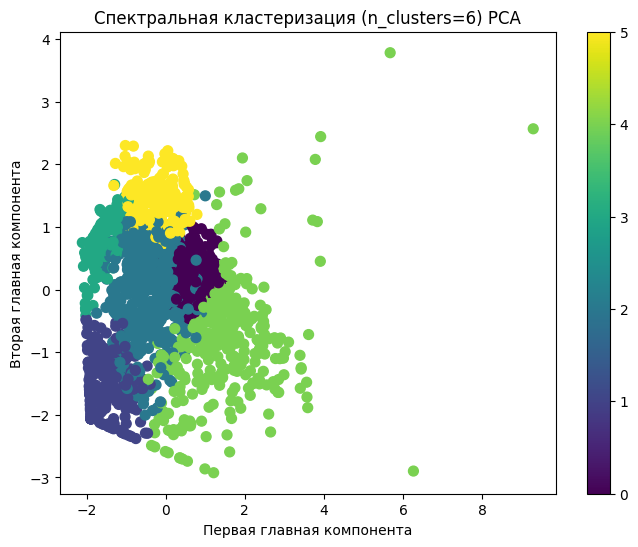

Количество кластеров: 6
Силуэтная оценка: 0.22
Индекс Дэвиса-Болдуина: 1.12
Индекс Калински-Харабаса: 557.17
--------------------------------------------------------------------------------


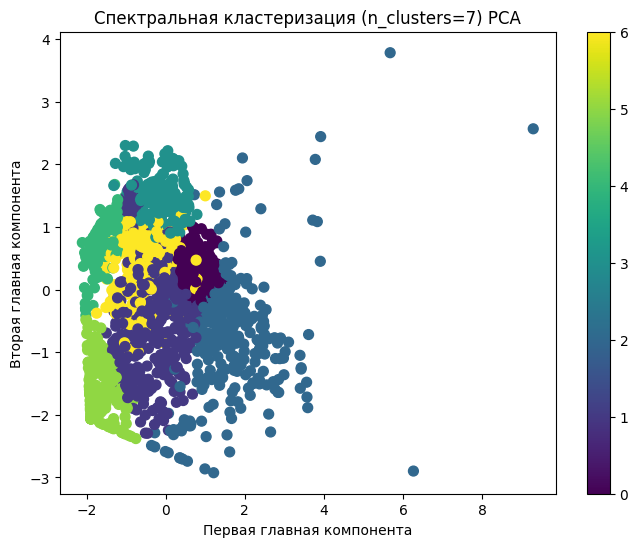

Количество кластеров: 7
Силуэтная оценка: 0.22
Индекс Дэвиса-Болдуина: 1.15
Индекс Калински-Харабаса: 498.26
--------------------------------------------------------------------------------


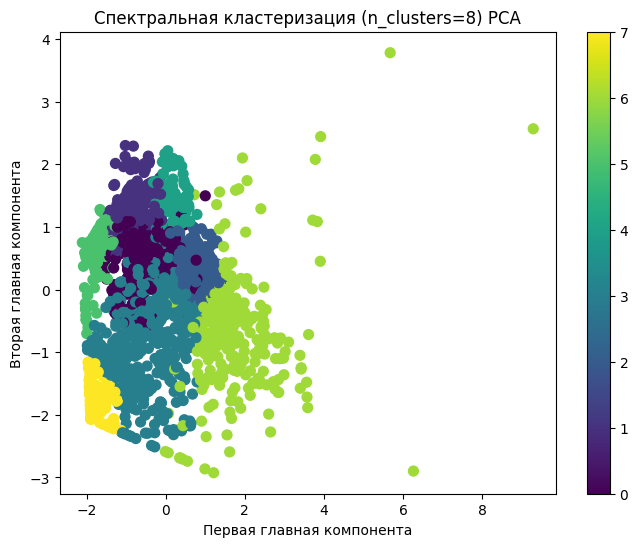

Количество кластеров: 8
Силуэтная оценка: 0.19
Индекс Дэвиса-Болдуина: 1.08
Индекс Калински-Харабаса: 457.16
--------------------------------------------------------------------------------


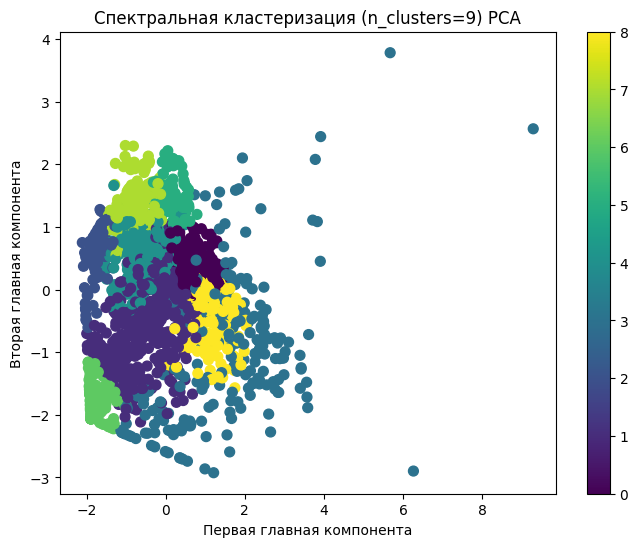

Количество кластеров: 9
Силуэтная оценка: 0.19
Индекс Дэвиса-Болдуина: 1.12
Индекс Калински-Харабаса: 423.06
--------------------------------------------------------------------------------


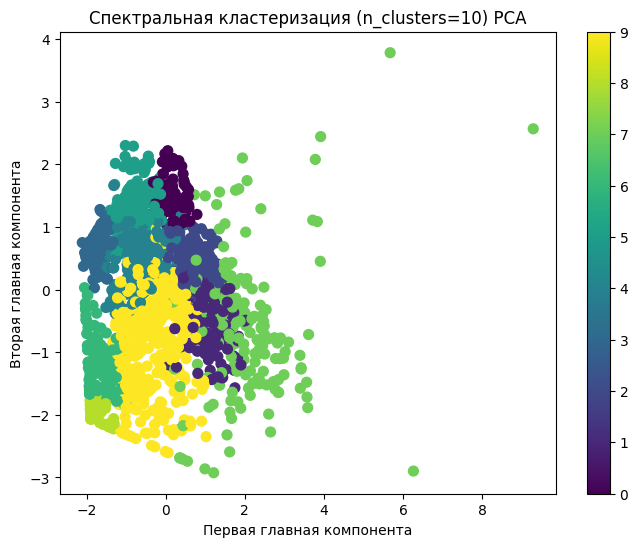

Количество кластеров: 10
Силуэтная оценка: 0.18
Индекс Дэвиса-Болдуина: 1.08
Индекс Калински-Харабаса: 443.46
--------------------------------------------------------------------------------


In [76]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Спектральная кластеризация и оценка
def perform_spectral_clustering(X_scaled, X_pca, n_clusters):
    

    # Применение спектральной кластеризации
    spectral = SpectralClustering(n_clusters=n_clusters,
                                    affinity='nearest_neighbors',
                                    random_state=42)
    predicted_labels = spectral.fit_predict(X_scaled)

    # Визуализация (для 2+ кластеров)
    if n_clusters > 1:
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, s=50, cmap='viridis')
        plt.title(f"Спектральная кластеризация (n_clusters={n_clusters}) PCA")
        plt.xlabel("Первая главная компонента")
        plt.ylabel("Вторая главная компонента")
        plt.colorbar()
        plt.show()

    # Вычисление метрик качества (для 2+ кластеров)
    if n_clusters > 1:
        silhouette_avg = silhouette_score(X_scaled, predicted_labels)
        davies_bouldin = davies_bouldin_score(X_scaled, predicted_labels)
        calinski_harabasz = calinski_harabasz_score(X_scaled, predicted_labels)
        print_scores(n_clusters, silhouette_avg, davies_bouldin, calinski_harabasz, None)
        

# Подготовка данных и масштабирование данных
X_scaled = get_X_scaled(X_encoded)

# Снижение размерности для визуализации (PCA)
X_pca, pca =  reduce_dimensions(X_scaled)



# Перебираем количество кластеров
for n_clusters in range(2, 11):
    perform_spectral_clustering(X_scaled, X_pca, n_clusters)

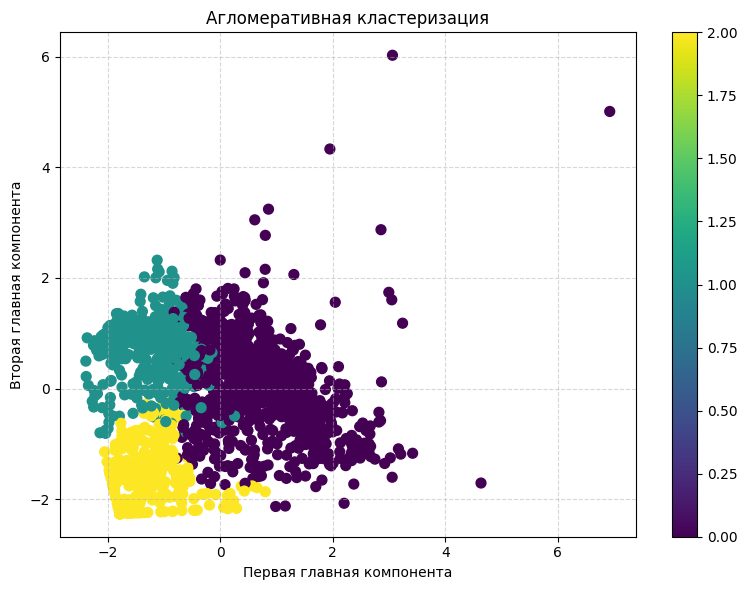

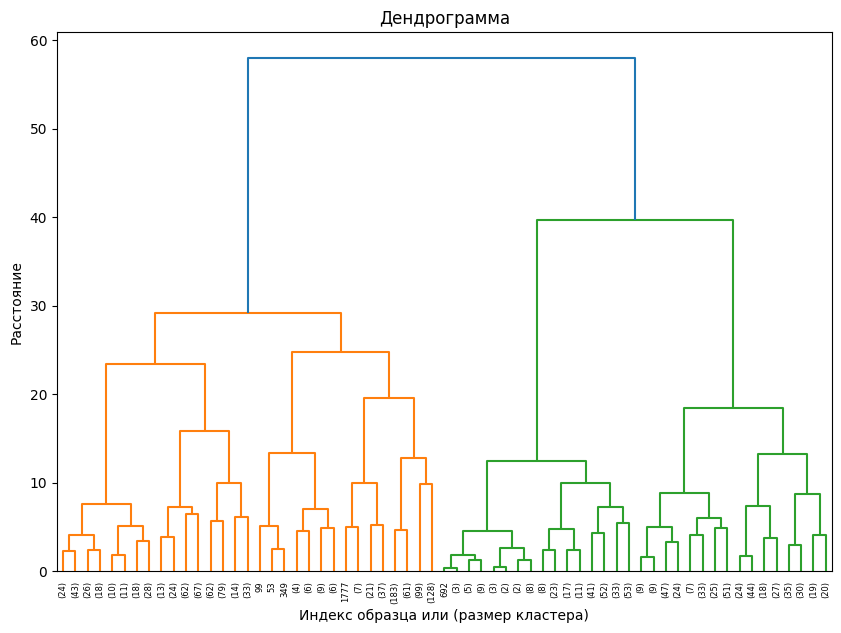

Силуэтная оценка: 0.33
Индекс Дэвиса-Болдуина: 0.98
Индекс Калински-Харабаса: 759.79
--------------------------------------------------------------------------------


In [129]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Функция для применения агломеративной кластеризации
def apply_agglomerative_clustering(X_scaled, n_clusters):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    return agg_clustering.fit_predict(X_scaled)





# Функция для визуализации дендрограммы
def plot_dendrogram(X_scaled):
    plt.figure(figsize=(10, 7))
    Z = linkage(X_scaled, method='ward')
    dendrogram(Z, truncate_mode='level', p=5)
    plt.title('Дендрограмма')
    plt.xlabel('Индекс образца или (размер кластера)')
    plt.ylabel('Расстояние')
    plt.show()

# Функция для вычисления метрик качества
def calculate_quality_metrics(labels, X_scaled):
    silhouette_avg = silhouette_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
    return silhouette_avg, davies_bouldin, calinski_harabasz


# Подготовка данных и масштабирование данных
X_scaled = get_X_scaled(X_encoded)

# Применение агломеративной кластеризации
n_clusters = 3  # Устанавливаем количество кластеров
predicted_labels = apply_agglomerative_clustering(X_scaled, n_clusters)

# Снижение размерности с использованием PCA для визуализации
X_pca, pca = reduce_dimensions(X_scaled)

# Визуализация кластеров после агломеративной кластеризации
visualize_clusters(X_pca, predicted_labels)

# Визуализация дендрограммы
plot_dendrogram(X_scaled)

# Вычисление и вывод метрик качества
silhouette_avg, davies_bouldin, calinski_harabasz = calculate_quality_metrics(predicted_labels, X_scaled)
print_scores(None, silhouette_avg, davies_bouldin, calinski_harabasz, None)

Найдено кластеров: 1
Количество шумовых точек: 171
Метки кластеров: [-1  0]


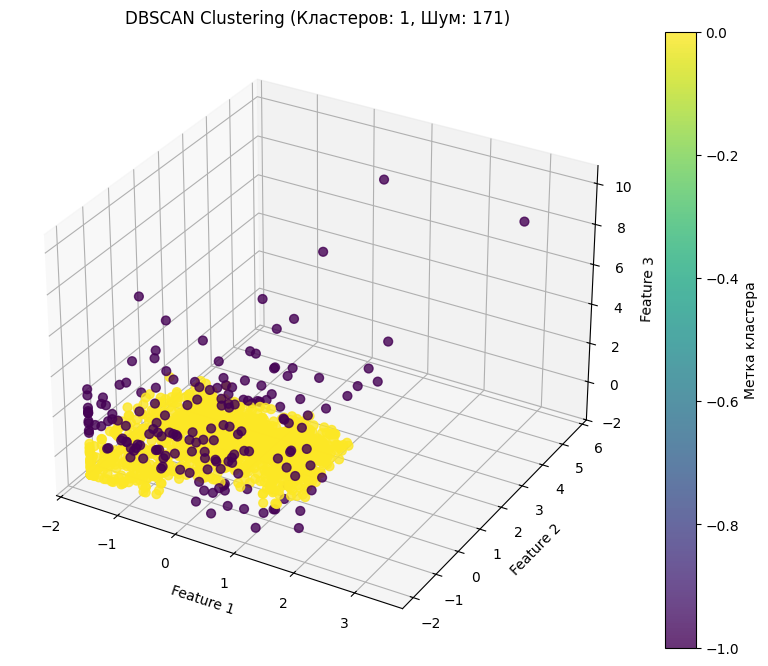

Количество кластеров: 1
--------------------------------------------------------------------------------


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV, cross_val_score  # Добавлено для подбора параметров и валидации
from sklearn.metrics import make_scorer  # Импортируем make_scorer

def apply_dbscan(data, eps=0.5, min_samples=15):
    """Применяет алгоритм DBSCAN к данным."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(data)

def analyze_results(labels):
    """Анализирует результаты кластеризации."""
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = np.sum(labels == -1)
    return n_clusters, n_noise, unique_labels

def visualize_clusters_3D(data, labels, n_clusters, n_noise):
    """Визуализирует кластеры в 3D."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2],
                         c=labels, cmap='viridis', s=40, alpha=0.8)

    ax.set_title(f"DBSCAN Clustering (Кластеров: {n_clusters}, Шум: {n_noise})")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")
    plt.colorbar(scatter, label='Метка кластера')
    plt.show()

def calculate_quality_metrics(labels, data):
    """Вычисляет метрики качества кластеризации."""
    mask = labels != -1  # Исключаем шум
    clustered_labels = labels[mask]
    clustered_data = data[mask]
    if len(np.unique(clustered_labels)) < 2:  # Проверяем количество кластеров
        return None, None, None

    if len(clustered_labels) < 2:
        return None, None, None

    silhouette = silhouette_score(clustered_data, clustered_labels)
    davies_bouldin = davies_bouldin_score(clustered_data, clustered_labels)
    calinski_harabasz = calinski_harabasz_score(clustered_data, clustered_labels)    
    return silhouette, davies_bouldin, calinski_harabasz


X_scaled = get_X_scaled(X_encoded)
predicted_labels = apply_dbscan(X_scaled)
n_clusters, n_noise, unique_labels = analyze_results(predicted_labels)


print(f"Найдено кластеров: {n_clusters}")
print(f"Количество шумовых точек: {n_noise}")
print(f"Метки кластеров: {unique_labels}")

visualize_clusters_3D(X_scaled, predicted_labels, n_clusters, n_noise)

silhouette, davies_bouldin, calinski_harabasz = calculate_quality_metrics(predicted_labels, X_scaled)
print_scores(n_clusters, silhouette, davies_bouldin, calinski_harabasz, None)

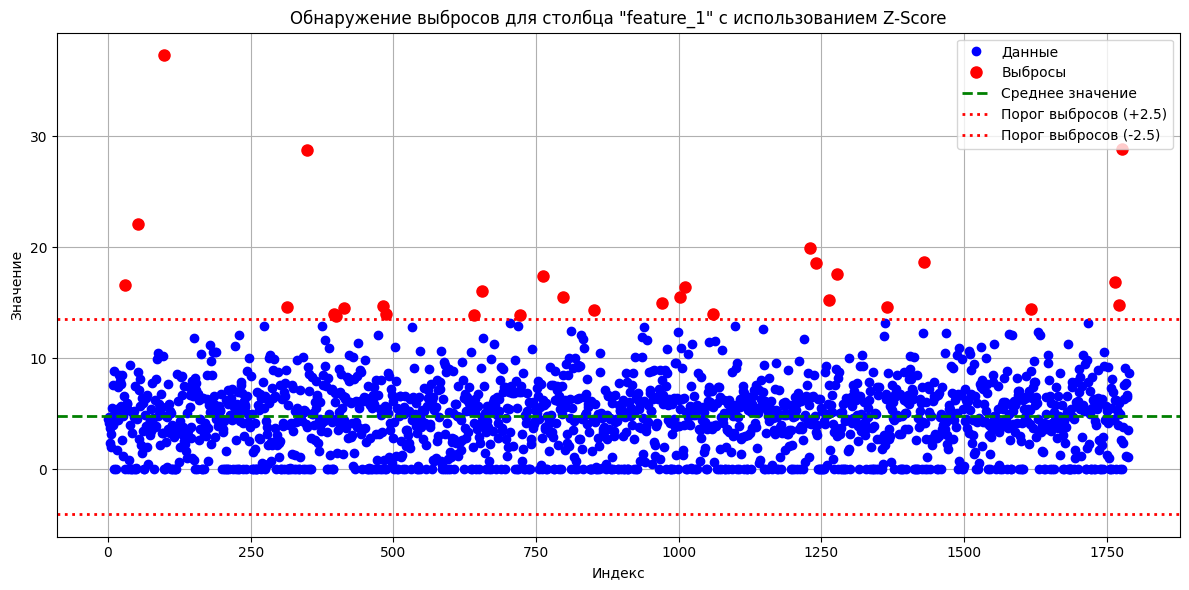

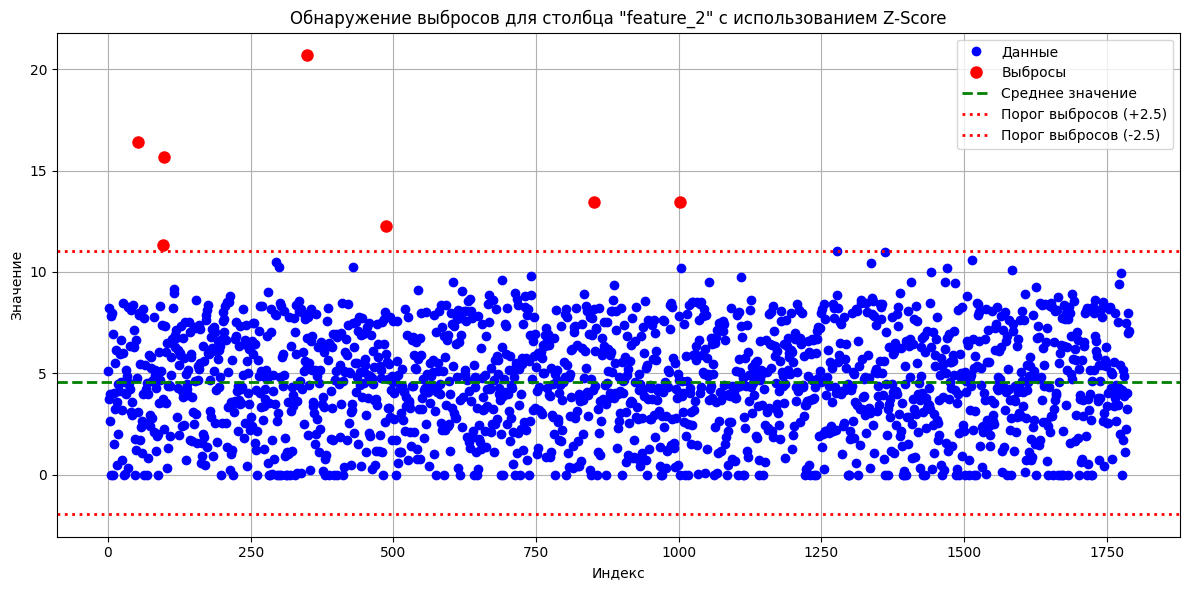

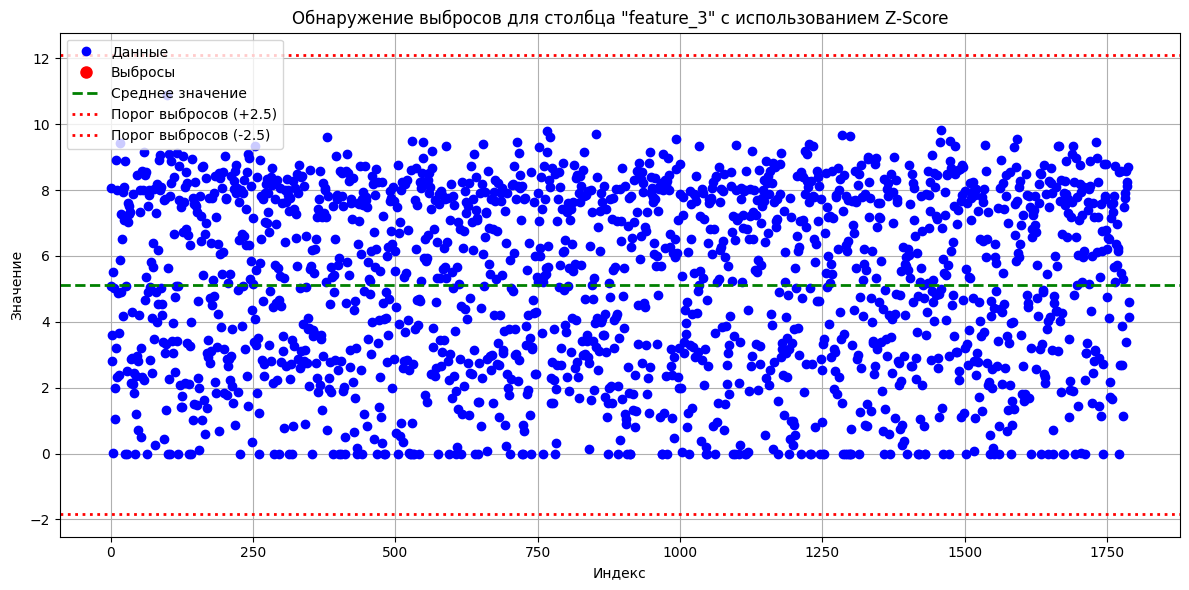

Найденные выбросы по столбцам:
  Столбец 'feature_1': [16.552322  22.064632  37.294598  14.628171  28.769363  14.024403
 13.811834  14.534665  14.703881  13.99833   13.867989  16.095785
 13.850671  17.403437  15.524265  14.3595705 15.015555  15.530909
 16.38456   14.0193615 19.928799  18.608112  15.203793  17.58403
 14.603093  18.697517  14.414947  16.879692  14.75815   28.840244 ]
  Столбец 'feature_2': [16.417654 11.315346 15.682354 20.670004 12.27313  13.445944 13.452703]
  Столбец 'feature_3': []


In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def detect_outliers_zscore(data, threshold=3, show_plot=True):
    """
    Обнаруживает выбросы в данных с использованием Z-оценок.

   
    """

    # Преобразование в numpy array или обработка pandas Series/DataFrame
    if isinstance(data, pd.DataFrame):
        outliers_all_columns = {}  # Словарь для хранения выбросов по столбцам
        for column in data.columns:
            column_data = data[column].copy()  # Создаем копию, чтобы не менять исходный DataFrame напрямую
            # Обработка NaN для каждого столбца
            mean = np.nanmean(column_data)
            std_dev = np.nanstd(column_data)
            if std_dev == 0: # Обработка случая нулевого стандартного отклонения
                z_scores = np.zeros(len(column_data))
            else:
                z_scores = (column_data - mean) / std_dev
            outliers_indices = np.where(np.abs(z_scores) > threshold)[0] # берем только индексы
            outliers_values = column_data.iloc[outliers_indices] # Используем .iloc для извлечения значений по индексам
            outliers_all_columns[column] = outliers_values # Сохраняем выбросы для каждого столбца

            if show_plot:
                plt.figure(figsize=(12, 6))  # Увеличиваем размер графика
                plt.plot(column_data.index, column_data, 'bo', label='Данные')  # Используем index для правильного отображения
                plt.plot(column_data.index[outliers_indices], outliers_values, 'ro', label='Выбросы', markersize=8)
                plt.axhline(mean, color='g', linestyle='dashed', linewidth=2, label='Среднее значение')
                plt.axhline(mean + threshold * std_dev, color='r', linestyle='dotted', linewidth=2, label=f'Порог выбросов (+{threshold})')
                plt.axhline(mean - threshold * std_dev, color='r', linestyle='dotted', linewidth=2, label=f'Порог выбросов (-{threshold})')
                plt.title(f'Обнаружение выбросов для столбца "{column}" с использованием Z-Score')
                plt.xlabel('Индекс')
                plt.ylabel('Значение')
                plt.legend()
                plt.grid(True)
                plt.tight_layout() # Улучшаем отображение, чтобы надписи не накладывались
                plt.show()

        print("Найденные выбросы по столбцам:")
        for column, outliers in outliers_all_columns.items():
            print(f"  Столбец '{column}': {outliers.values if isinstance(outliers,pd.Series) else outliers}")  # Выводим значения выбросов
        return outliers_all_columns  # Возвращаем словарь с выбросами по столбцам

    elif isinstance(data, (pd.Series, np.ndarray, list)):
        # Обработка Series, numpy array и list
        data = np.array(data)  # Преобразуем в numpy array для единообразия

        # Вычисление Z-оценок
        mean = np.nanmean(data)
        std_dev = np.nanstd(data)
        if std_dev == 0:  # Обработка случая нулевого стандартного отклонения
            z_scores = np.zeros(len(data))
        else:
            z_scores = (data - mean) / std_dev

        # Поиск выбросов
        outliers_indices = np.where(np.abs(z_scores) > threshold)[0] # Исправлено: берем только индексы
        outliers_values = data[outliers_indices]

        if show_plot:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(data)), data, 'bo', label='Данные') # Исправлено: используем range для индексов
            plt.plot(outliers_indices, outliers_values, 'ro', label='Выбросы', markersize=8) # Исправлено: используем только индексы
            plt.axhline(mean, color='g', linestyle='dashed', linewidth=2, label='Среднее значение')
            plt.axhline(mean + threshold * std_dev, color='r', linestyle='dotted', linewidth=2, label='Порог выбросов')
            plt.axhline(mean - threshold * std_dev, color='r', linestyle='dotted', linewidth=2)
            plt.title('Обнаружение выбросов с использованием Z-Score')
            plt.xlabel('Индекс')
            plt.ylabel('Значение')
            plt.legend()
            plt.grid(True)
            plt.show()

        print("Найденные выбросы:", outliers_values)
        return outliers_values

    else:
        raise ValueError("Неподдерживаемый тип входных данных.  Допустимы: numpy array, list, pandas Series, pandas DataFrame.")


data = pd.DataFrame(X_encoded, columns=['feature_1', 'feature_2', 'feature_3']) 
outliers = detect_outliers_zscore(data, threshold=2.5)